In [43]:
library(repr)
options(repr.plot.width=10, repr.plot.height=5, repr.plot.res = 180)

In [233]:
library(tictoc)
library(tidyverse)
library(infer)

# 1. Hits vs. Non-hits on cell culture rna-seq data

In [5]:
setwd("/gpfs/commons/groups/sanjana_lab/cdai/TFscreen")

_**Import RNA-seq data:**_

In [320]:
# Import rna-seq data
sheets = readxl::excel_sheets("RNA-seq_timepoint_deseq_result_20200102.xlsx")
rna_data = map(sheets, ~ readxl::read_excel("RNA-seq_timepoint_deseq_result_20200102.xlsx", .x))
names(rna_data) = sheets
# list of TF gene names
tflist = read.csv('TFlist_20191230.csv', stringsAsFactors = F) %>% pull(hgnc_symbol)
# list hit TF
hitlist = read.csv('Hitlist_20191230.csv', stringsAsFactors = F) %>% pull(hgnc_symbol)
# sample name annotations
all.sample.annotation = read.csv('RNASeqSampleNames.csv', stringsAsFactors=F)

# get all releveant ES, H15, D1, d2, D4, D7 samples' read counts
wt_cnts = select(rna_data$rawCounts, gene_id:S02_B2, S15_B1:S20_B2, S07_B1:S08_B2, S21_B1:S22_B2)

# remove genes with low read counts
select.rows = rowSums(select(wt_cnts, S01_B1:S22_B2)) >= 100
wt_cnts = wt_cnts[select.rows,]

# normalize reads to RPKM and select only TFs
tf_norm_cnts = select(wt_cnts, -gene_id, -gene_name) %>% 
                    apply(2, function(x) { 1e6 * x / sum(x) } ) %>% 
                    as_tibble

tf_norm_cnts = cbind(wt_cnts[, 1:2], tf_norm_cnts) # add gene id and gene names
tf_norm_cnts = filter(tf_norm_cnts, gene_name %in% tflist) # select only TF
tf_norm_cnts = mutate(tf_norm_cnts, screen = if_else(gene_name %in% hitlist, 'Hit', 'Non-hit')) # add screen result
tf_norm_cnts = mutate_at(tf_norm_cnts, 'screen', ~ factor(.x, levels = c('Hit', 'Non-hit'))) # make screen factor

In [561]:
# combine replicates using median
tf_norm_median = data.frame(ES = pmap_dbl(select(tf_norm_cnts, S01_B1:S02_B2), ~ median(..1, ..2, ..3, ..4)), 
                           H15 = pmap_dbl(select(tf_norm_cnts, S15_B1:S16_B2), ~ median(..1, ..2, ..3, ..4)),
                           D1 = pmap_dbl(select(tf_norm_cnts, S17_B1:S18_B2), ~ median(..1, ..2, ..3, ..4)),
                           D2 = pmap_dbl(select(tf_norm_cnts, S19_B1:S20_B2), ~ median(..1, ..2, ..3, ..4)),
                           D4 = pmap_dbl(select(tf_norm_cnts, S07_B1:S08_B2), ~ median(..1, ..2, ..3, ..4)),
                           D7 = pmap_dbl(select(tf_norm_cnts, S21_B1:S22_B2), ~ median(..1, ..2, ..3, ..4))
                          )

tf_norm_median = cbind(tf_norm_cnts[, c('gene_id', 'gene_name', 'screen')], tf_norm_median)
# scale median RPKM using SD
#tf_norm_median_scale = mutate_at(tf_norm_median, `.vars` = c('ES','H15','D1','D2','D4','D7'), .funs = ~ scale(.x, center = F, scale = T)[,1])

In [1024]:
tf_norm_median[, 3:9] %>% group_by(screen) %>% sample_n(size = 5, replace = T)

screen,ES,H15,D1,D2,D4,D7
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Hit,4.461303,4.233835,26.311474,6.303525,3.575993,1.629883
Hit,3.212138,15.469781,0.000000,12.431953,47.052544,42.376956
Hit,55.677062,129.457638,73.197333,173.522042,228.298943,174.397473
Hit,0.000000,6.513592,29.872425,12.957246,65.308931,38.573896
Hit,8.030345,2.116917,3.560951,9.280190,14.492184,38.845543
Non-hit,16.060691,11.561625,11.672007,25.389199,9.222299,5.704590
Non-hit,28.552339,34.196357,45.501045,52.179181,46.111493,170.866060
Non-hit,0.000000,0.000000,0.000000,0.000000,0.000000,13.310711
Non-hit,13.027005,3.419636,0.000000,3.501958,2.446732,5.432943


##### Build null distribution
1. sample hit/non-hit with replacement
2. randomly reassign hits vs non hits
2. calculate the difference of the means
3. build null distribution of the difference of the means (imagine histogram) $\delta = \mu_{hit} - \mu_{nonHit}$
4. calculate p-value:  then two.sided p-value = proportion observed > abs(delta)

In [377]:
minus = function(v) {
    # Given a vector v, return v[1] - v[2]
    if (length(v == 2)) {
        v.result = v[1] - v[2]
    } else {
        print('Input must be a vector of length 2')
    }
}

In [481]:
# sample once and calculate the difference of means of one instance of a null distribution
diffMeans = function(df, .size = 80) {
    # Given a formatted dataframe, return the differences of the means
    # first column of df must be screen('Hit', or 'Non-hit'), all other columns are RPKM values
    # sample_length is the number of rows to sample from
    # output is a single row dataframe, indicating hit vs non-hit difference of the means for each time point / sample (in column)
    cols = colnames(df)[-1]
    
    df.sub = group_by(df, screen) %>% 
                    sample_n(size = .size, replace = T) # sampling with replacement %>%
                    ungroup
    
    screen.rand = sample(df.sub$screen) # permute 'hit' vs. 'non-hit' label
    df.sub$screen = screen.rand
    means = summarise_at(df.sub, cols, mean) # calculate means
    diff.means = select(means, -screen) %>% map_df(minus) # diff of means of null
    
    return(diff.means)
}

In [555]:
get.p = function(null.dist, t) {
    # two.sided test, get pvalue from null distribution
    # null.dist is a vector of difference of means
    # t is given statistics
    length(null.dist[null.dist > abs(t) | null.dist < -1 * abs(t)]) / length(null.dist)
}

In [562]:
diffMeans(tf_norm_median[, 3:9], 5)

ES,H15,D1,D2,D4,D7
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
-16.95295,-14.49274,-18.63565,-8.369681,-1.129261,16.29883


# Get p-value for hits vs non-hits in cell culture

In [734]:
# Build null distribution for ES, H15, D1, D2, D4, D7
# sample with placement for 1000 times, each sample, take 60 TFs
nulls1 = map_df(1:2000, ~ diffMeans(df = select(tf_norm_median, -c('gene_id', 'gene_name')), .size = 60))

In [735]:
nulls1 %>% head(1)
str(nulls1)

ES,H15,D1,D2,D4,D7
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
-53.63081,-37.40973,-38.05602,-2.060319,17.41258,17.96946


tibble [2,000 × 6] (S3: tbl_df/tbl/data.frame)
 $ ES : num [1:2000] -53.63 -1.64 -8.59 -0.66 -21.08 ...
 $ H15: num [1:2000] -37.41 -11.63 -5.17 13.63 -9.69 ...
 $ D1 : num [1:2000] -38.06 -11.46 -4.62 10.35 -10.11 ...
 $ D2 : num [1:2000] -2.06 -17.75 -1.34 22.76 -11.82 ...
 $ D4 : num [1:2000] 17.41 -12.31 1.14 24.09 -6.02 ...
 $ D7 : num [1:2000] 17.97 5.01 11.65 43.88 -9.33 ...


In [752]:
hist1 = map(colnames(nulls1), ~ggplot(nulls1) + geom_histogram(aes_string(x = .x), bins = 100) + coord_cartesian(xlim = c(-300, 300)))

#### Null distribution (mean of Hits  - mean of Non-hits)

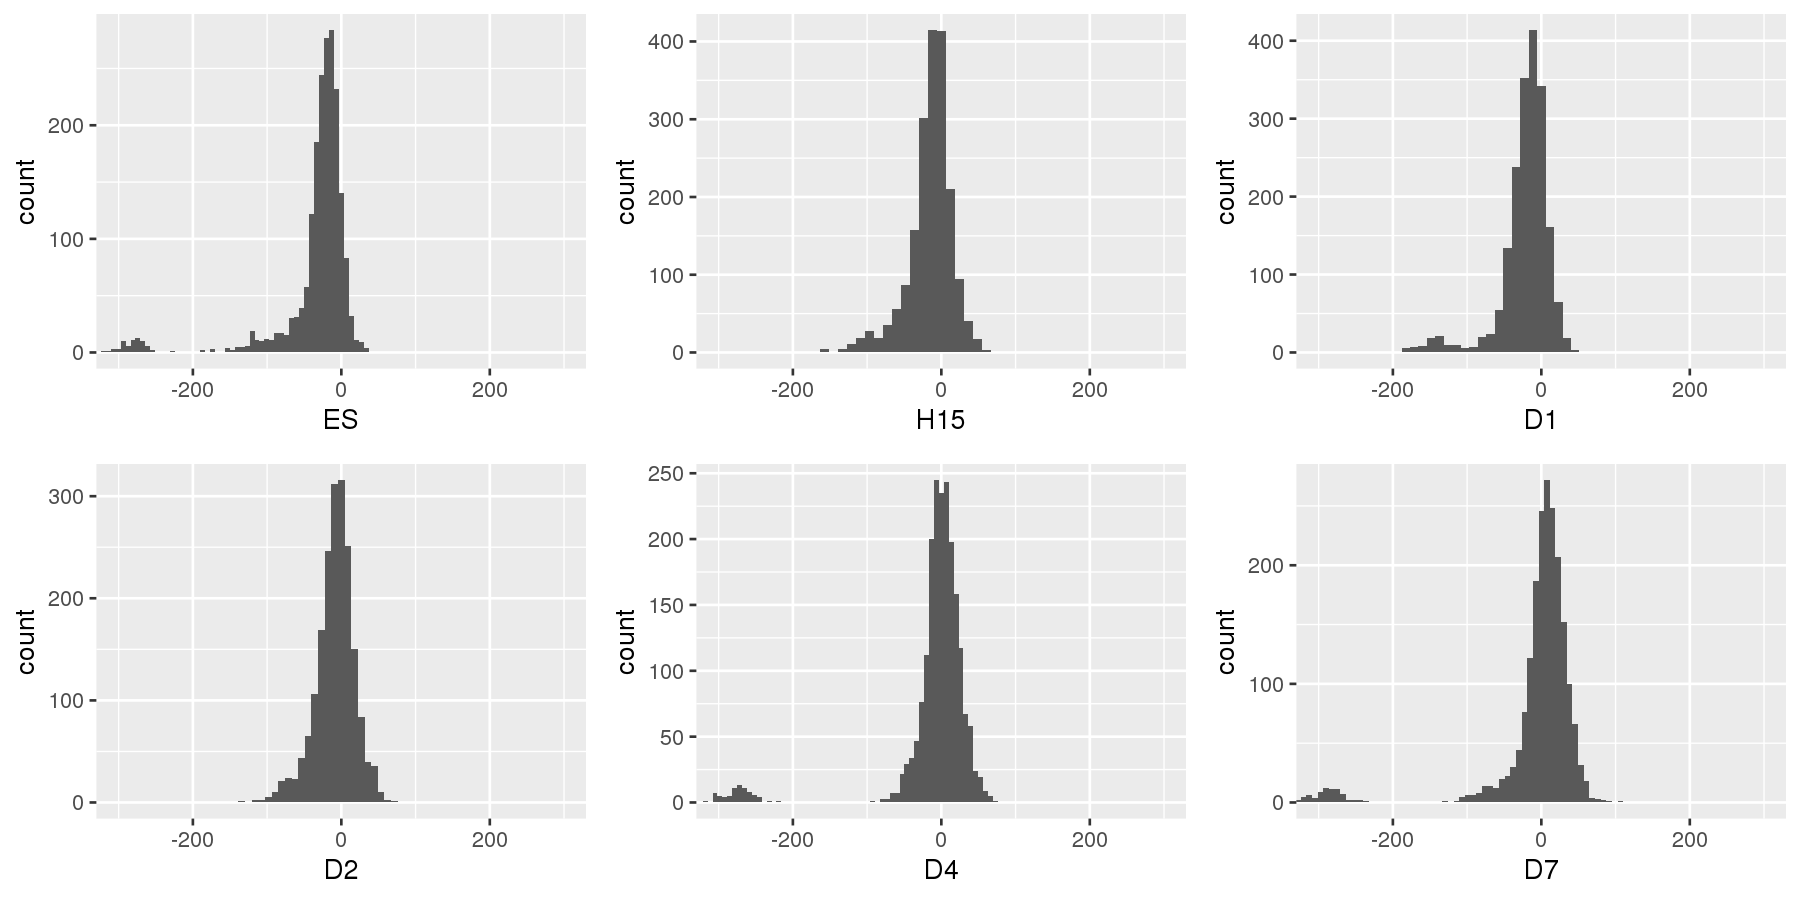

In [753]:
gridExtra::grid.arrange(grobs = hist1, nrow = 2)

In [740]:
rpkm.cutoffs1 = seq(1, 500, 2)

In [769]:
p_cutoff_analysis = lapply(rpkm.cutoffs1, function(cutoff) map_dbl(nulls1, ~ get.p(.x, cutoff))) %>%
                do.call(rbind,.) %>% as.data.frame %>%
                add_column(t_cutoff = rpkm.cutoffs1)

In [770]:
hist1.2 = map(colnames(nulls1), ~ ggplot(p_cutoff_analysis) + geom_line(aes_string('t_cutoff', .x), alpha = .7) + 
              geom_hline(yintercept = 0.05, color = 'red') + 
              coord_cartesian(ylim = c(0,.3)) +
              labs(x = 'cutoff(hit - non-hit)'))

#### p-values at different cutoffs

cutoff = absolute value of (mean of hit TF RPKM - mean of non-hit TF RPKM)

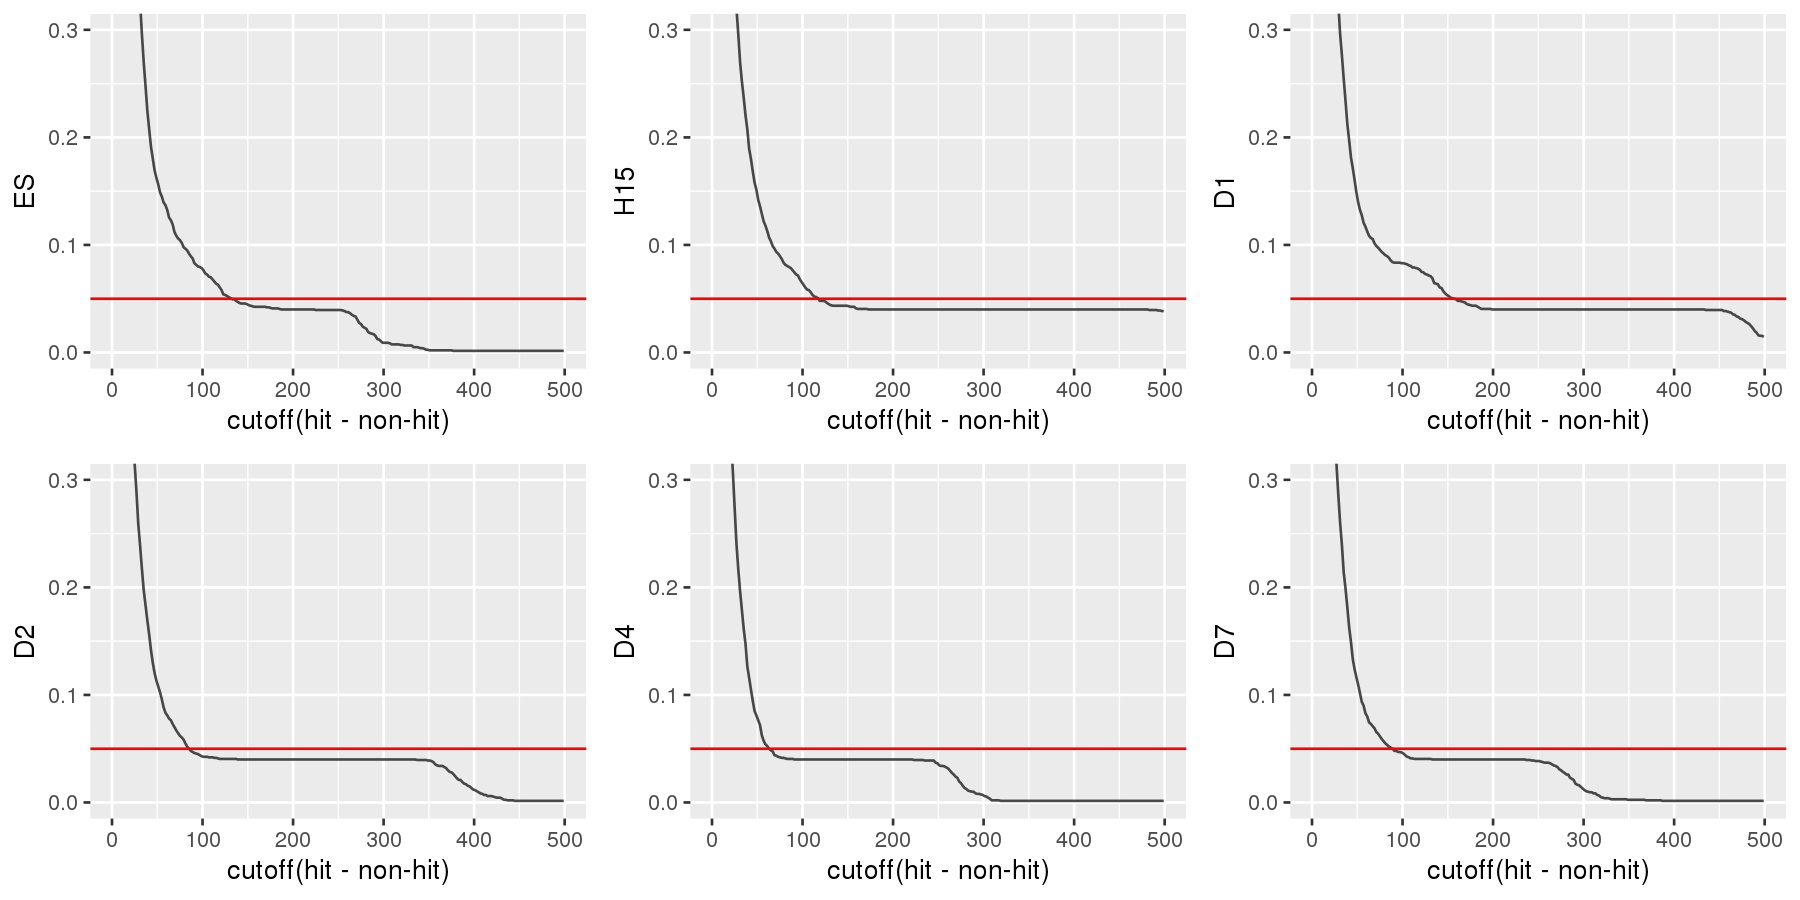

In [771]:
gridExtra::grid.arrange(grobs = hist1.2, nrow = 2)

#### Calculate p-values for cell culture

In [1025]:
diff.means1 = tf_norm_median[, 3:9] %>% 
                group_by(screen) %>% 
                summarise_at(c('ES', 'H15', 'D1', 'D2', 'D4', 'D7'), mean) %>%
                select(-screen) %>% map_df(minus)

In [1026]:
diff.means1

ES,H15,D1,D2,D4,D7
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
-37.15834,-36.93582,-41.04463,-24.10019,-10.02977,-5.831678


In [772]:
pvals1 = map2(diff.means1, nulls1, ~ get.p(null.dist = .y, t = .x))

In [780]:
pvals1 %>% t

ES,H15,D1,D2,D4,D7
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.2465,0.2215,0.1965,0.331,0.636,0.812


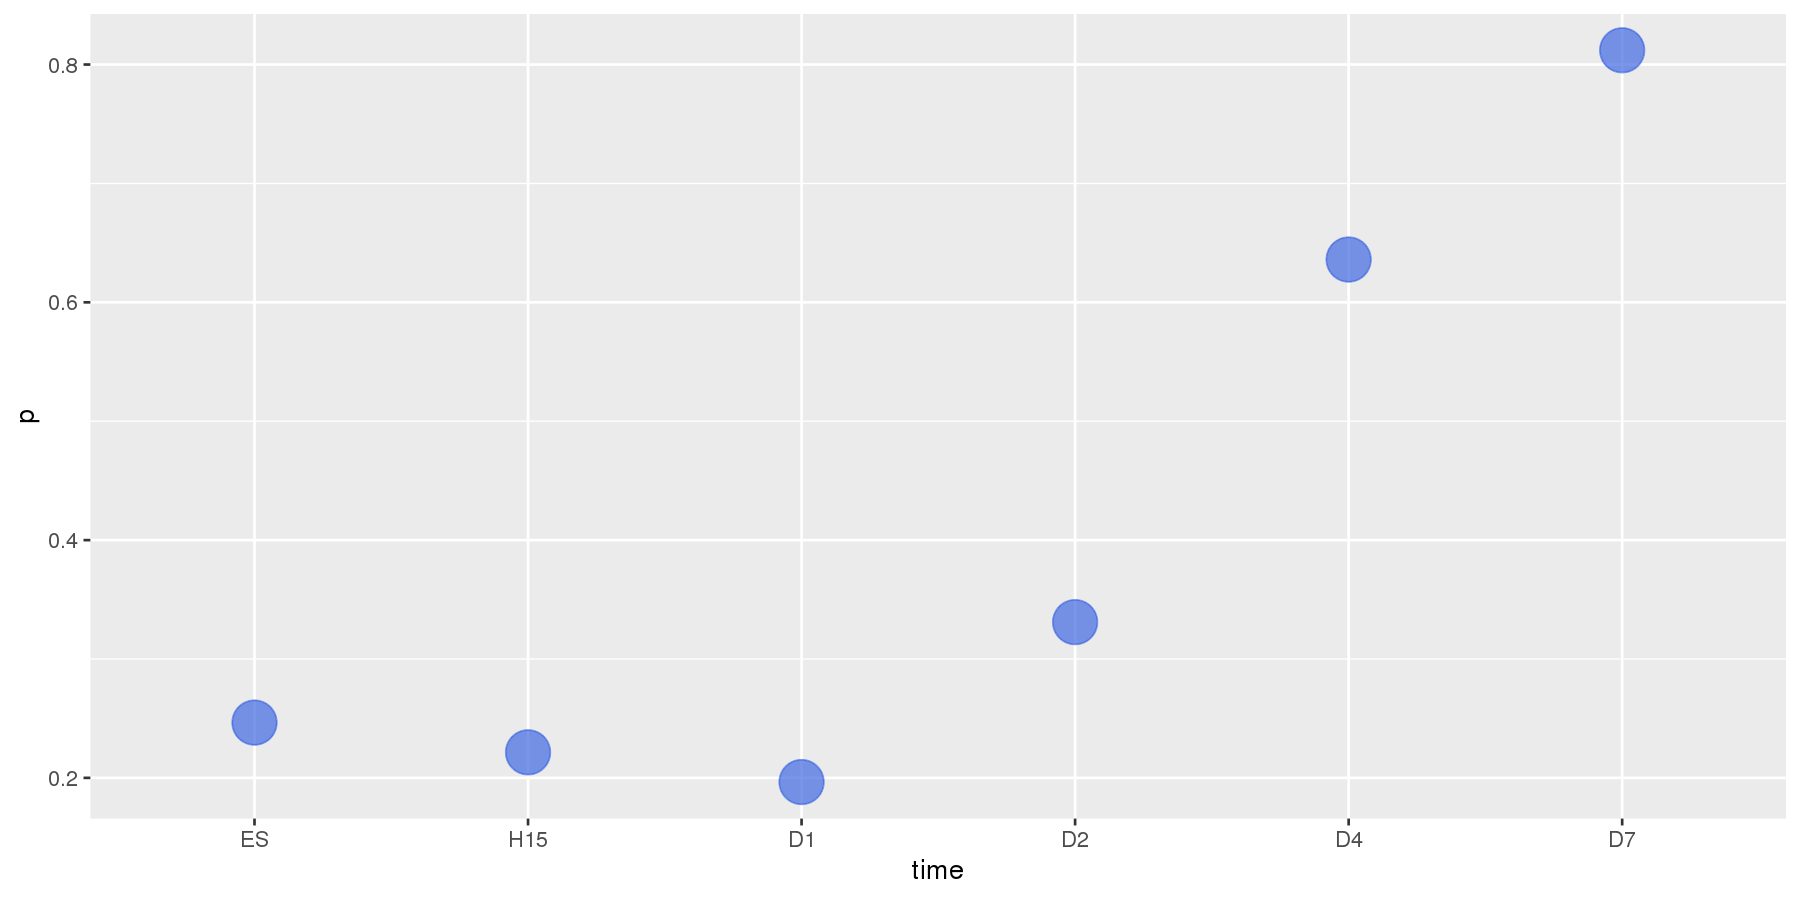

In [1064]:
pvals1 %>% unlist %>% enframe %>% rename('time' = 'name', 'p'='value') %>% 
        mutate_at('time', ~ factor(.x, levels = c('ES', 'H15', 'D1', 'D2', 'D4', 'D7'))) %>%
        arrange(time) %>%
        ggplot() + geom_point(aes(time, p), size = 8, color = 'royalblue', alpha = .7)

# Hits vs. Non-hits on Alan brain map

In [782]:
# import sample data
brain.structures = c('CBC', 'DFC', 'S1C', 'STR')

In [795]:
sample.fnames = map_chr(brain.structures, ~ paste0('expressionBySample_', .x, '.csv'))

In [805]:
expression.bySample = map(sample.fnames, ~ read.table(.x, header = T, sep = ',', stringsAsFactors = F))

In [811]:
names(expression.bySample) = brain.structures

In [817]:
suppressMessages({genelookup <- read_csv('ProteinGeneList_20191230.csv')})

In [823]:
gene_lookup = mutate(genelookup, screen = if_else(gene_name %in% hitlist, 'Hit', 'Non-hit'))

In [831]:
filter(gene_lookup, isTF) %>% head

gene_id,gene_name,isTF,screen
<chr>,<chr>,<lgl>,<chr>
ENSG00000001167,NFYA,TRUE,Non-hit
ENSG00000004848,ARX,TRUE,Non-hit
ENSG00000005007,UPF1,TRUE,Non-hit
ENSG00000005075,POLR2J,TRUE,Hit
ENSG00000005102,MEOX1,TRUE,Non-hit
ENSG00000005302,MSL3,TRUE,Non-hit


In [810]:
colnames(expression.bySample[[1]])

[1] "X12.pcw" "X16.pcw" "X17.pcw" "X21.pcw" "X24.pcw" "X35.pcw" "X37.pcw"
 [8] "X4.mos"  "X10.mos" "X1.yrs"  "X2.yrs"  "X3.yrs"  "X4.yrs"  "X8.yrs" 
[15] "X11.yrs" "X13.yrs" "X15.yrs" "X18.yrs" "X19.yrs" "X21.yrs" "X23.yrs"
[22] "X30.yrs" "X36.yrs" "X37.yrs" "X40.yrs"

In [851]:
brain_tf = map(expression.bySample, ~ rownames_to_column(.x, 'gene_id') %>%
                    inner_join(filter(gene_lookup, isTF), by = 'gene_id') %>%
                    select(-isTF) %>%
                    .[, sort(colnames(.))]
              )

In [852]:
map(brain_tf[1:2], ~head(.x,1))

,gene_id,gene_name,screen,X1.yrs,X10.mos,X11.yrs,X12.pcw,X13.yrs,X15.yrs,X16.pcw,⋯,X3.yrs,X30.yrs,X35.pcw,X36.yrs,X37.pcw,X37.yrs,X4.mos,X4.yrs,X40.yrs,X8.yrs
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ENSG00000001167,NFYA,Non-hit,10.62579,6.986148,9.945318,14.87088,8.977464,8.673379,10.65772,⋯,8.141673,8.863209,3.931589,9.706696,8.841376,4.745133,7.967112,4.77915,3.941297,6.190328
,gene_id,gene_name,screen,X1.yrs,X10.mos,X11.yrs,X12.pcw,X13.pcw,X13.yrs,X16.pcw,⋯,X30.yrs,X36.yrs,X37.pcw,X37.yrs,X4.mos,X4.yrs,X40.yrs,X8.pcw,X8.yrs,X9.pcw
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ENSG00000001167,NFYA,Non-hit,4.750881,1.615889,4.677051,63.31631,39.18523,3.942167,22.72784,⋯,5.051708,5.91373,6.218894,9.288165,5.283894,1.400896,4.062579,22.91924,4.010563,25.76319


In [ ]:
# build null distribution for brain samples

In [909]:
select(brain_tf[['CBC']], -c('gene_id', 'gene_name')) %>% head(2)

,screen,X1.yrs,X10.mos,X11.yrs,X12.pcw,X13.yrs,X15.yrs,X16.pcw,X17.pcw,X18.yrs,⋯,X3.yrs,X30.yrs,X35.pcw,X36.yrs,X37.pcw,X37.yrs,X4.mos,X4.yrs,X40.yrs,X8.yrs
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Non-hit,10.625790,6.986148,9.945318,14.87088,8.977464,8.673379,10.657717,10.806877,4.085308,⋯,8.141673,8.863209,3.931589,9.706696,8.841376,4.745133,7.967112,4.77915,3.941297,6.190328
2,Non-hit,0.012806,0.012704,0.000000,0.00000,0.000000,0.000000,0.069669,0.386385,0.402176,⋯,0.000000,0.000000,0.049715,0.015923,0.000000,0.028747,0.000000,0.00000,0.000000,0.000000


In [953]:
tic()

In [954]:
alan.results = list()
for (struc in brain.structures[1:4]) {
    # calc null distribution (sampling 2000 times) for each time point
    nulls2 = map_df(1:2000, ~ diffMeans(df = select(brain_tf[[struc]], -c('gene_id', 'gene_name')), `.size` = 60))
    # histogram of null distribution
    hist2 = map(colnames(nulls2), ~ ggplot(nulls2) + 
                geom_histogram(aes_string(x = .x), bins = 100))
    # mean of hit vs non hit
    diff.means2 = select(brain_tf[[struc]], -c('gene_id', 'gene_name')) %>%
                        group_by(screen) %>%
                        summarise_all(mean) %>%
                        select(-screen) %>%
                        map_df(minus)
    # calculate p.value
    pvals2 = map2(nulls2, diff.means2, ~ get.p(.x, .y))
    
    alan.results[[struc]][['null.dist']] = nulls2
    alan.results[[struc]][['histogram']] = hist2
    alan.results[[struc]][['diff.of.means']] = diff.means2
    alan.results[[struc]][['p.val']] = pvals2
}

In [955]:
toc()

273.172 sec elapsed


In [ ]:
time.order = rep(1:50)

In [976]:
time.order = c(paste0('X', 1:50, '.pcw'), paste0('X', 1:12, '.mos'), paste0('X', 1:100, '.yrs'))
time.order = factor(time.order, levels = time.order)

---

#### CBC null distribution & p values

In [1044]:
alan.results$CBC$diff.of.means %>% colnames
alan.results$CBC$diff.of.means %>% colnames %>% factor(., levels = time.order) %>% order

[1] "X1.yrs"  "X10.mos" "X11.yrs" "X12.pcw" "X13.yrs" "X15.yrs" "X16.pcw"
 [8] "X17.pcw" "X18.yrs" "X19.yrs" "X2.yrs"  "X21.pcw" "X21.yrs" "X23.yrs"
[15] "X24.pcw" "X3.yrs"  "X30.yrs" "X35.pcw" "X36.yrs" "X37.pcw" "X37.yrs"
[22] "X4.mos"  "X4.yrs"  "X40.yrs" "X8.yrs"

[1]  4  7  8 12 15 18 20 22  2  1 11 16 23 25  3  5  6  9 10 13 14 17 19 21 24

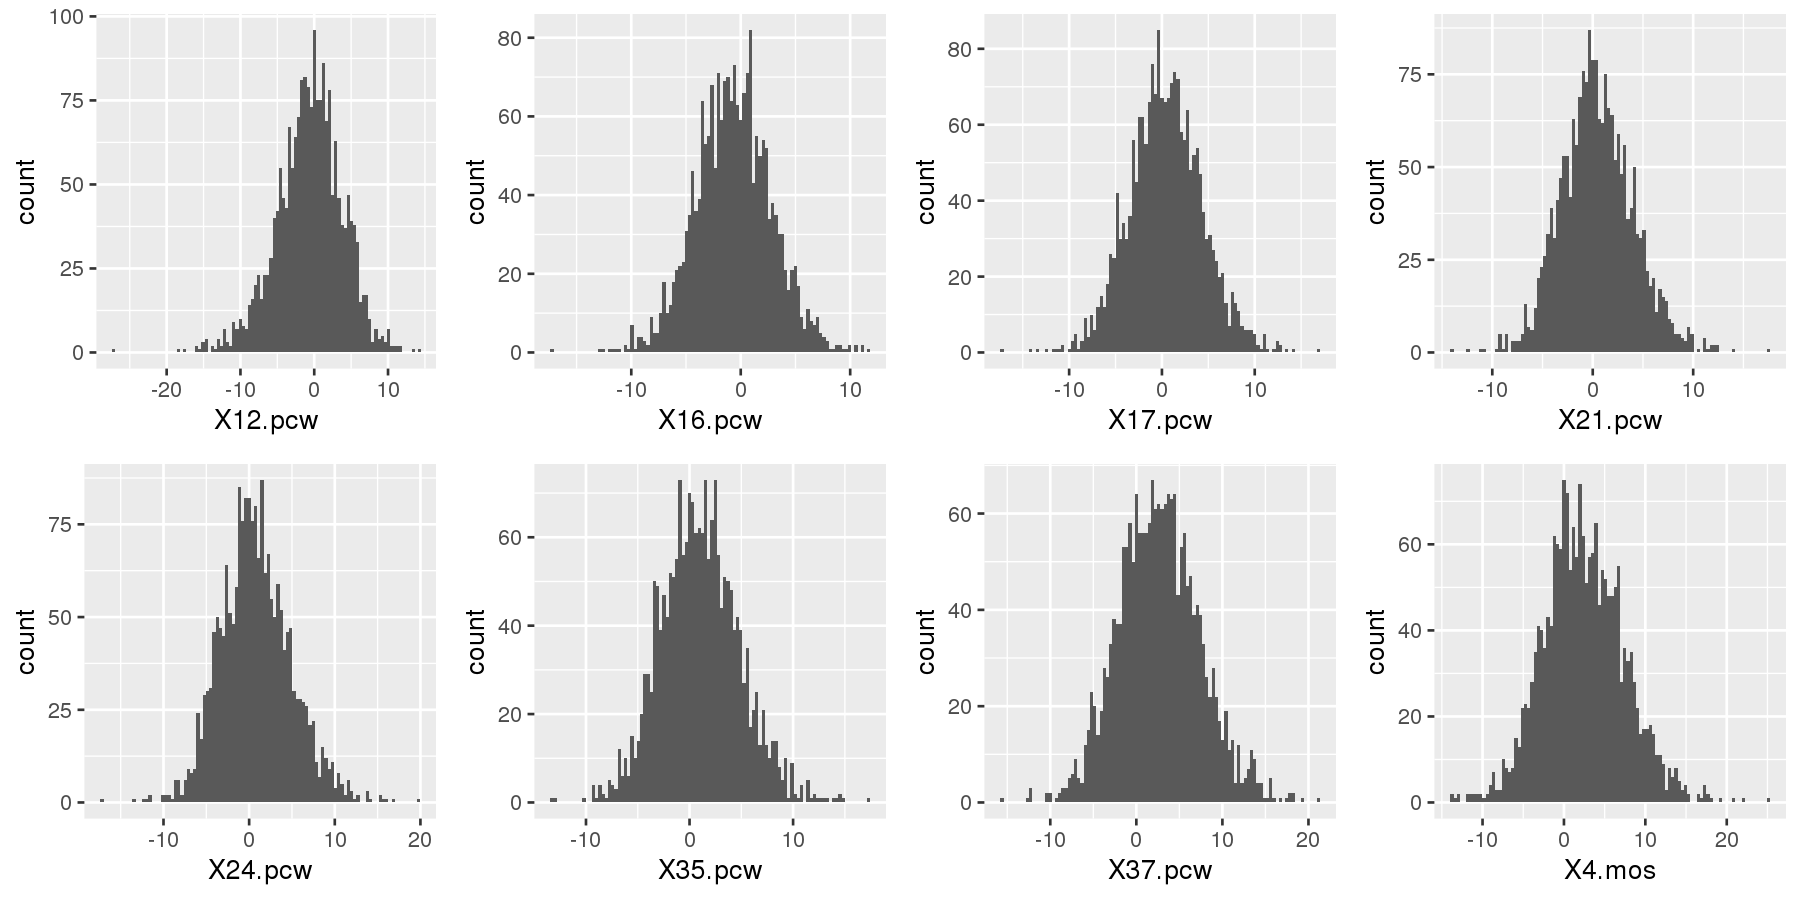

In [1049]:
gridExtra::grid.arrange(grobs = alan.results$CBC$histogram[c(4,7,8,12,15,18,20,22)], nrow = 2)

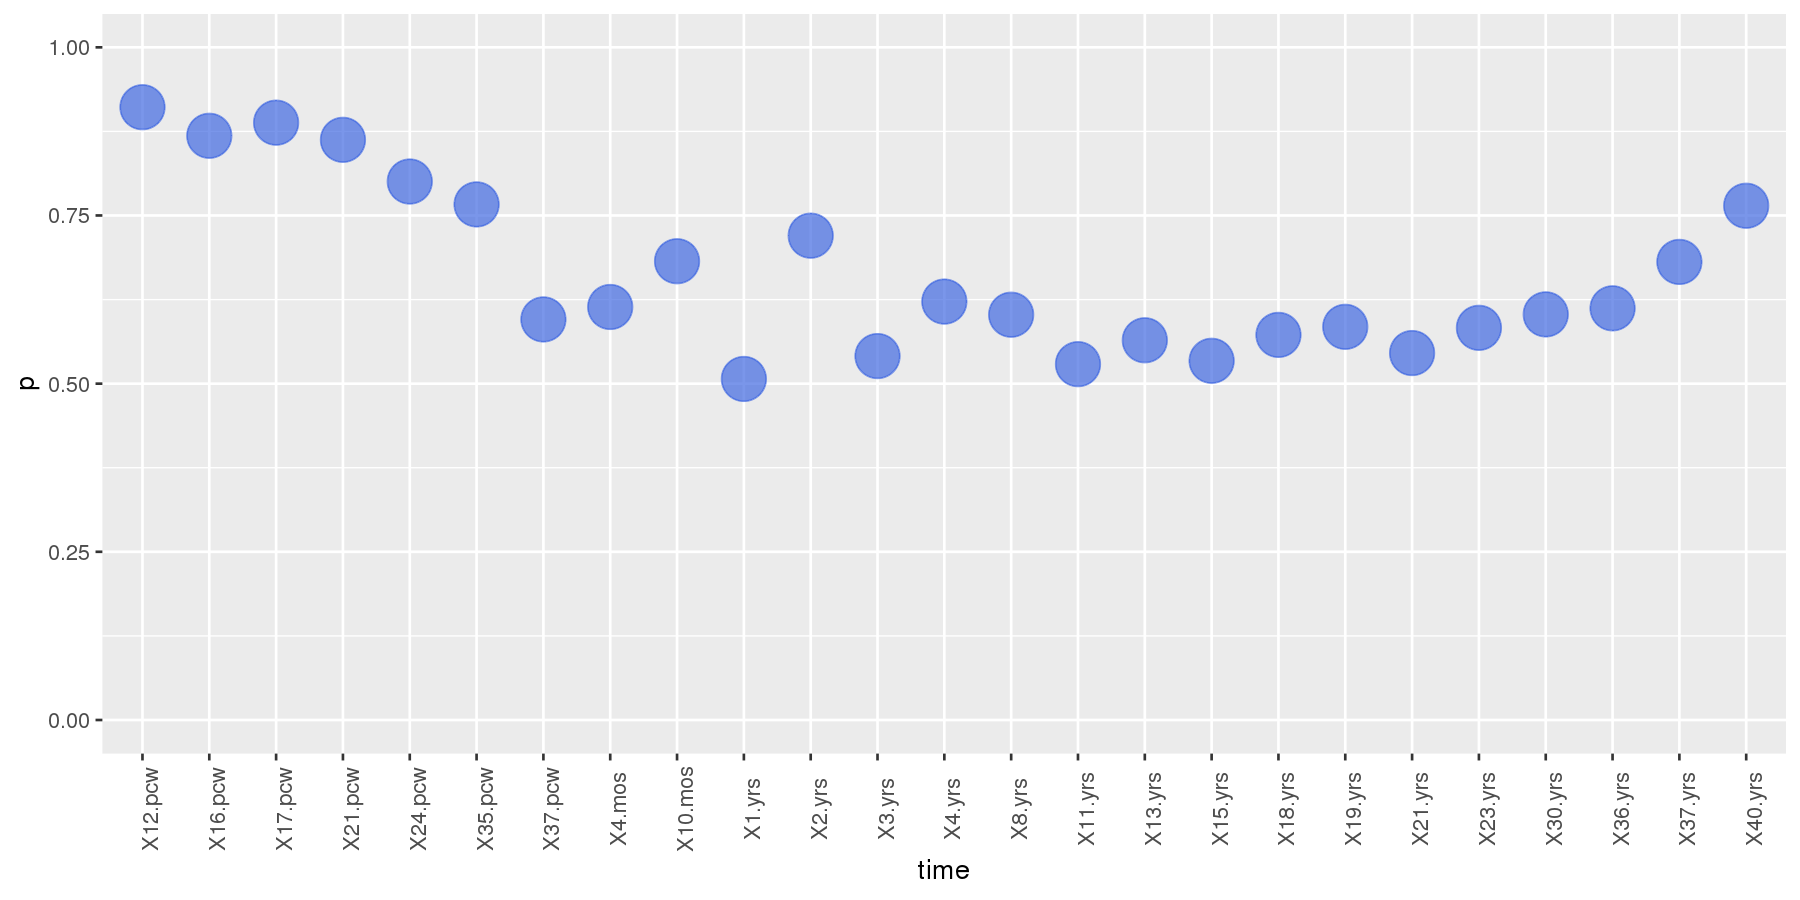

In [1065]:
alan.results$CBC$p.val %>% unlist %>% enframe %>%
    rename('time'='name', 'p' = 'value') %>% mutate_at('time', ~ factor(.x, levels = time.order)) %>%
    arrange(time) %>%
    ggplot() + geom_point(aes(time, p), size = 8, color = 'royalblue', alpha = .7) + 
        ylim(c(0,1)) +
        theme(axis.text.x = element_text(angle = 90))

---

#### DFC null distribution & p values

In [1050]:
alan.results$DFC$diff.of.means %>% colnames
alan.results$DFC$diff.of.means %>% colnames %>% factor(., levels = time.order) %>% order

[1] "X1.yrs"  "X10.mos" "X11.yrs" "X12.pcw" "X13.pcw" "X13.yrs" "X16.pcw"
 [8] "X17.pcw" "X18.yrs" "X19.pcw" "X19.yrs" "X2.yrs"  "X21.pcw" "X21.yrs"
[15] "X24.pcw" "X26.pcw" "X3.yrs"  "X30.yrs" "X36.yrs" "X37.pcw" "X37.yrs"
[22] "X4.mos"  "X4.yrs"  "X40.yrs" "X8.pcw"  "X8.yrs"  "X9.pcw"

[1] 25 27  4  5  7  8 10 13 15 16 20 22  2  1 12 17 23 26  3  6  9 11 14 18 19
[26] 21 24

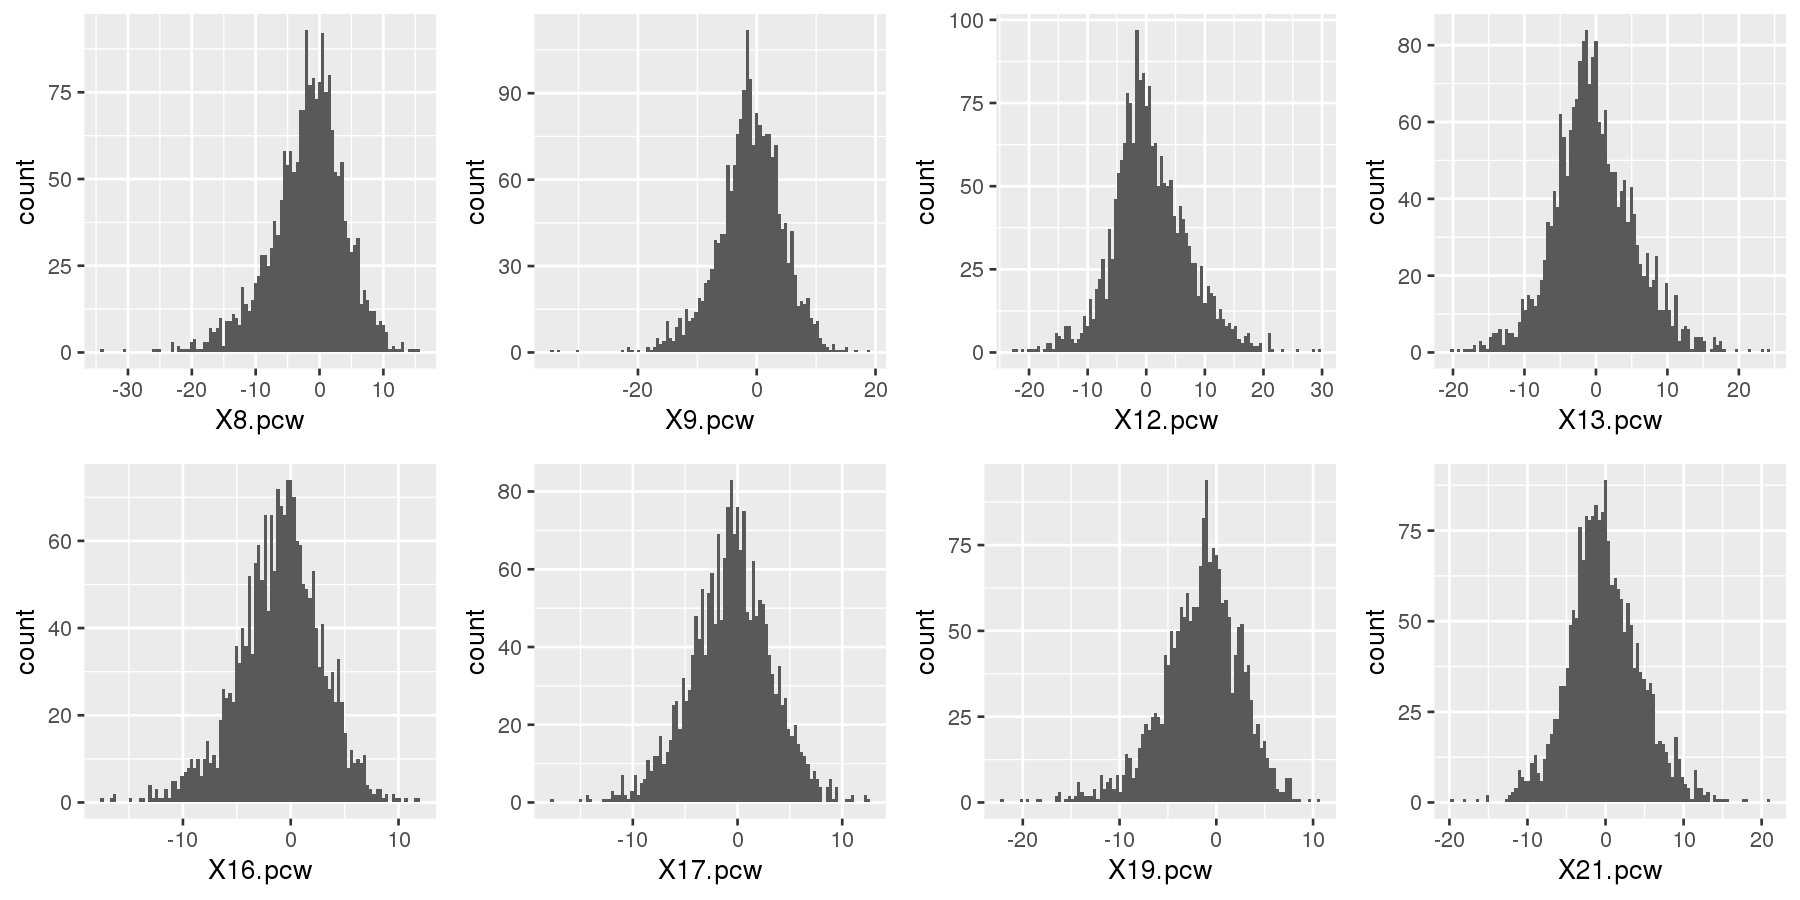

In [1053]:
gridExtra::grid.arrange(grobs = alan.results$DFC$histogram[c(25, 27, 4, 5, 7, 8, 10, 13)], nrow = 2)

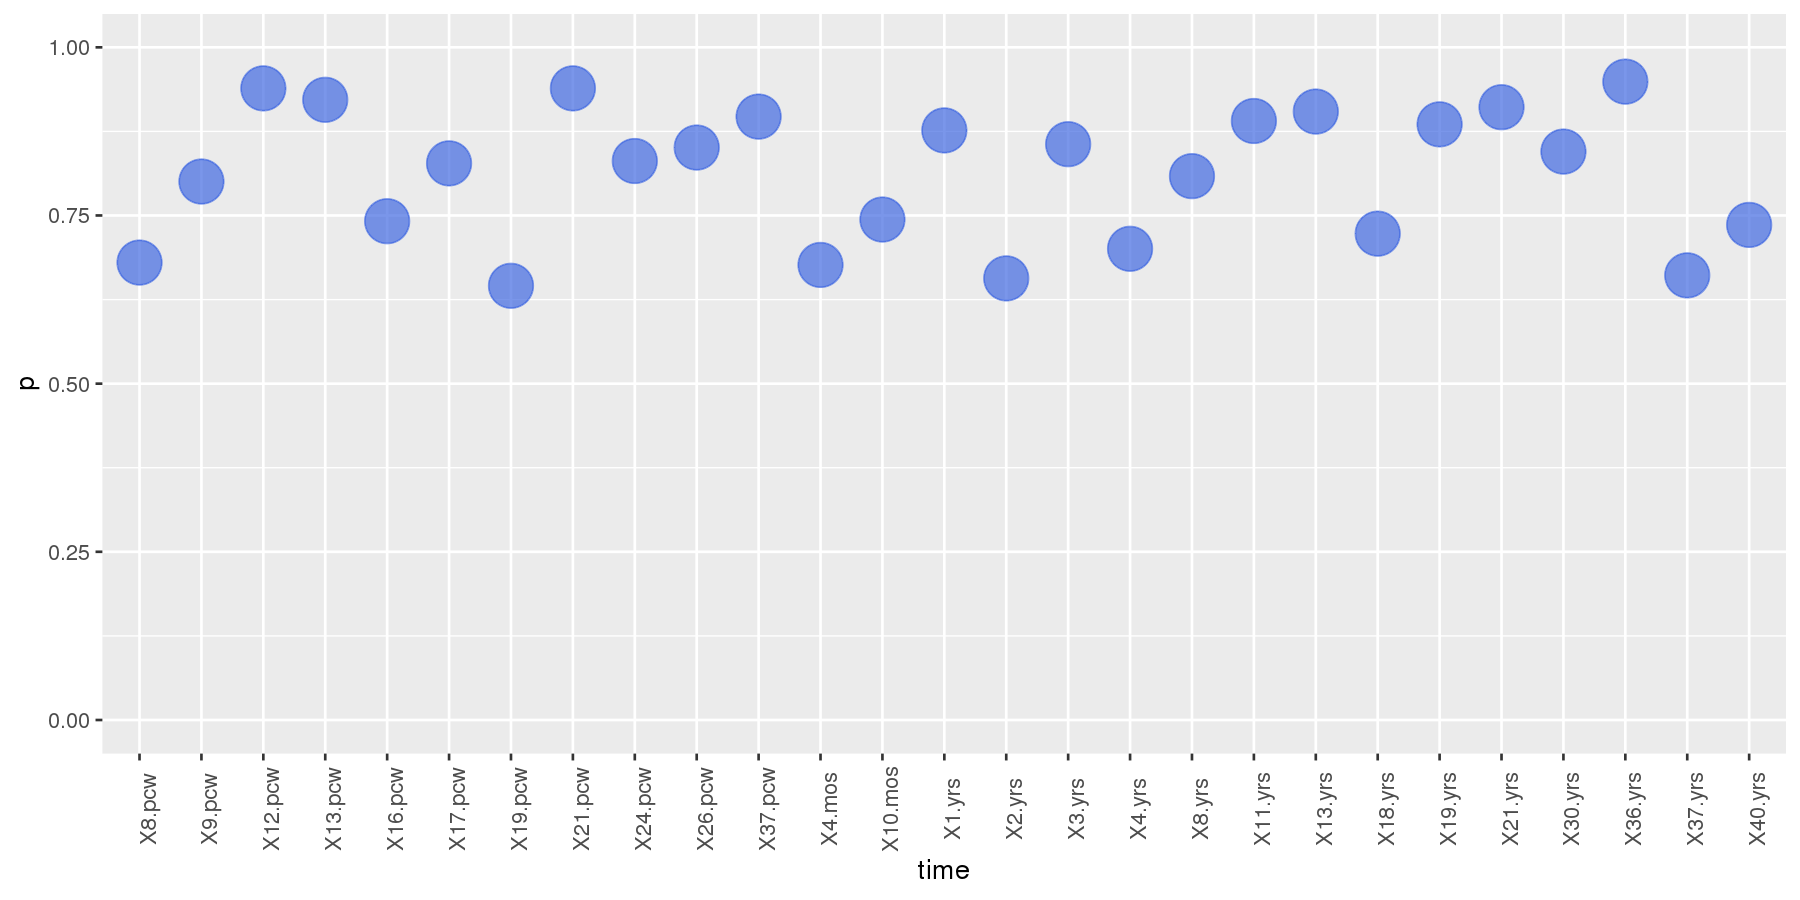

In [1066]:
alan.results$DFC$p.val %>% unlist %>% enframe %>%
    rename('time'='name', 'p' = 'value') %>% mutate_at('time', ~ factor(.x, levels = time.order)) %>%
    arrange(time) %>%
    ggplot() + geom_point(aes(time, p), size = 8, color = 'royalblue', alpha = .7) + 
        ylim(c(0,1)) +
        theme(axis.text.x = element_text(angle = 90))

---
#### S1C null distribution & p values

In [1054]:
alan.results$S1C$diff.of.means %>% colnames
alan.results$S1C$diff.of.means %>% colnames %>% factor(., levels = time.order) %>% order

[1] "X1.yrs"  "X10.mos" "X11.yrs" "X12.pcw" "X13.pcw" "X13.yrs" "X16.pcw"
 [8] "X18.yrs" "X19.yrs" "X2.yrs"  "X21.pcw" "X21.yrs" "X23.yrs" "X24.pcw"
[15] "X3.yrs"  "X30.yrs" "X36.yrs" "X37.pcw" "X37.yrs" "X4.mos"  "X40.yrs"
[22] "X8.yrs"

[1]  4  5  7 11 14 18 20  2  1 10 15 22  3  6  8  9 12 13 16 17 19 21

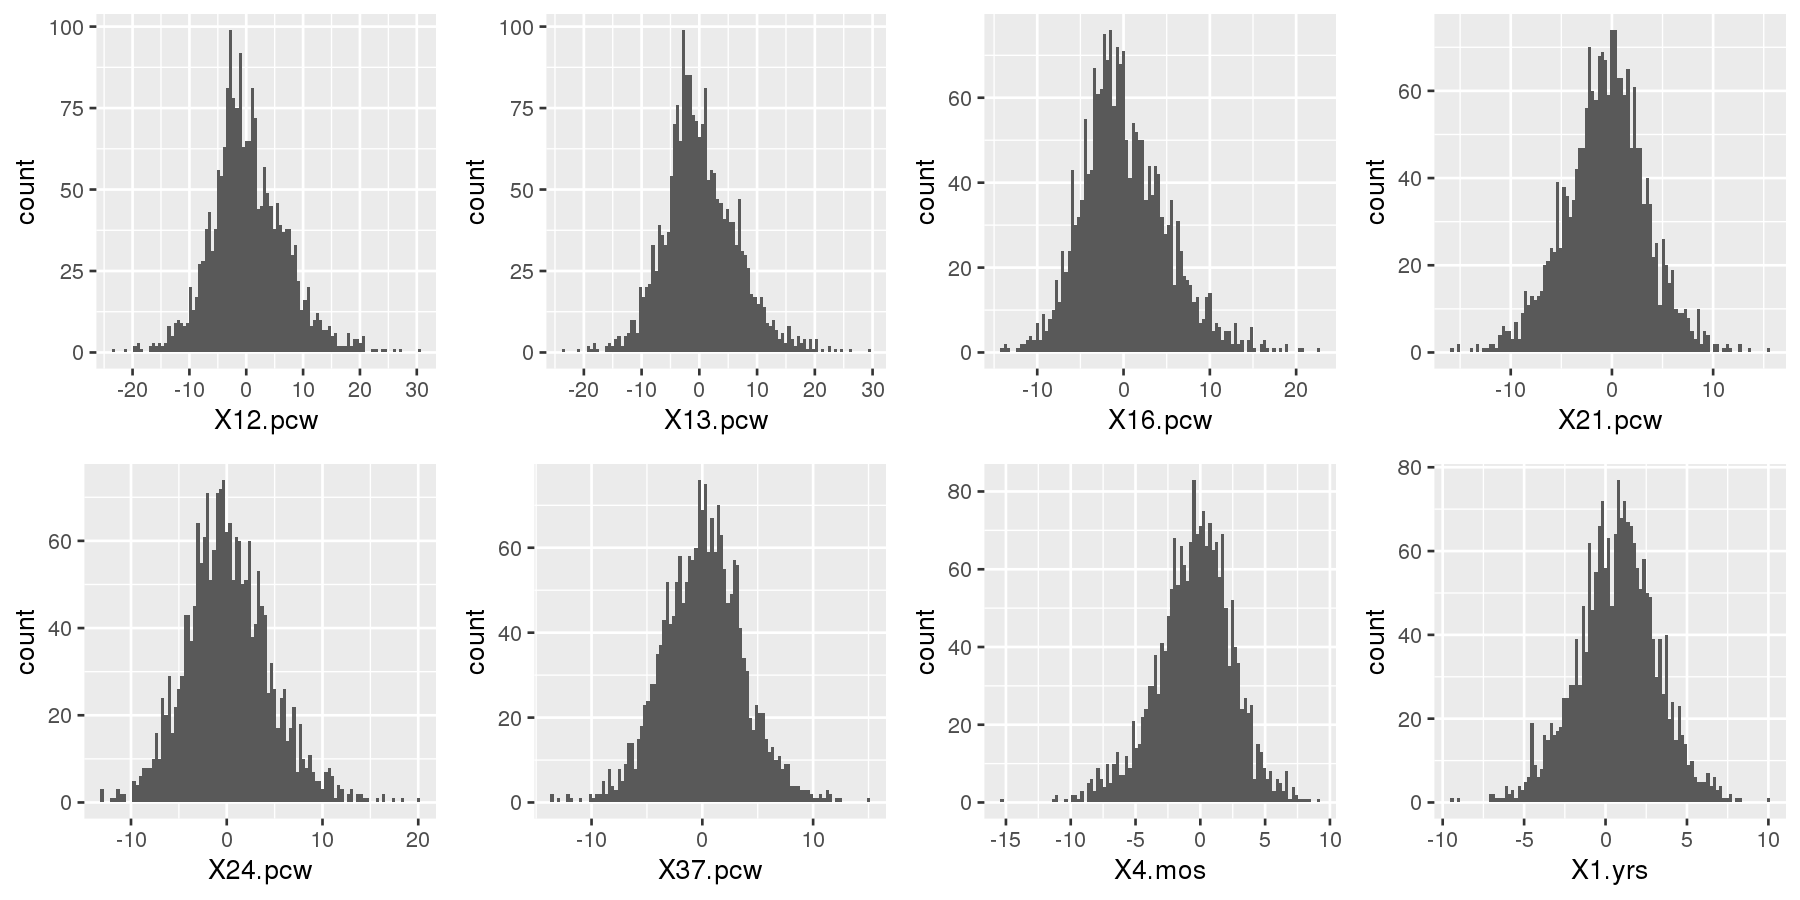

In [1055]:
gridExtra::grid.arrange(grobs = alan.results$S1C$histogram[c(4,5,7,11,14,18,20,1)], nrow = 2)

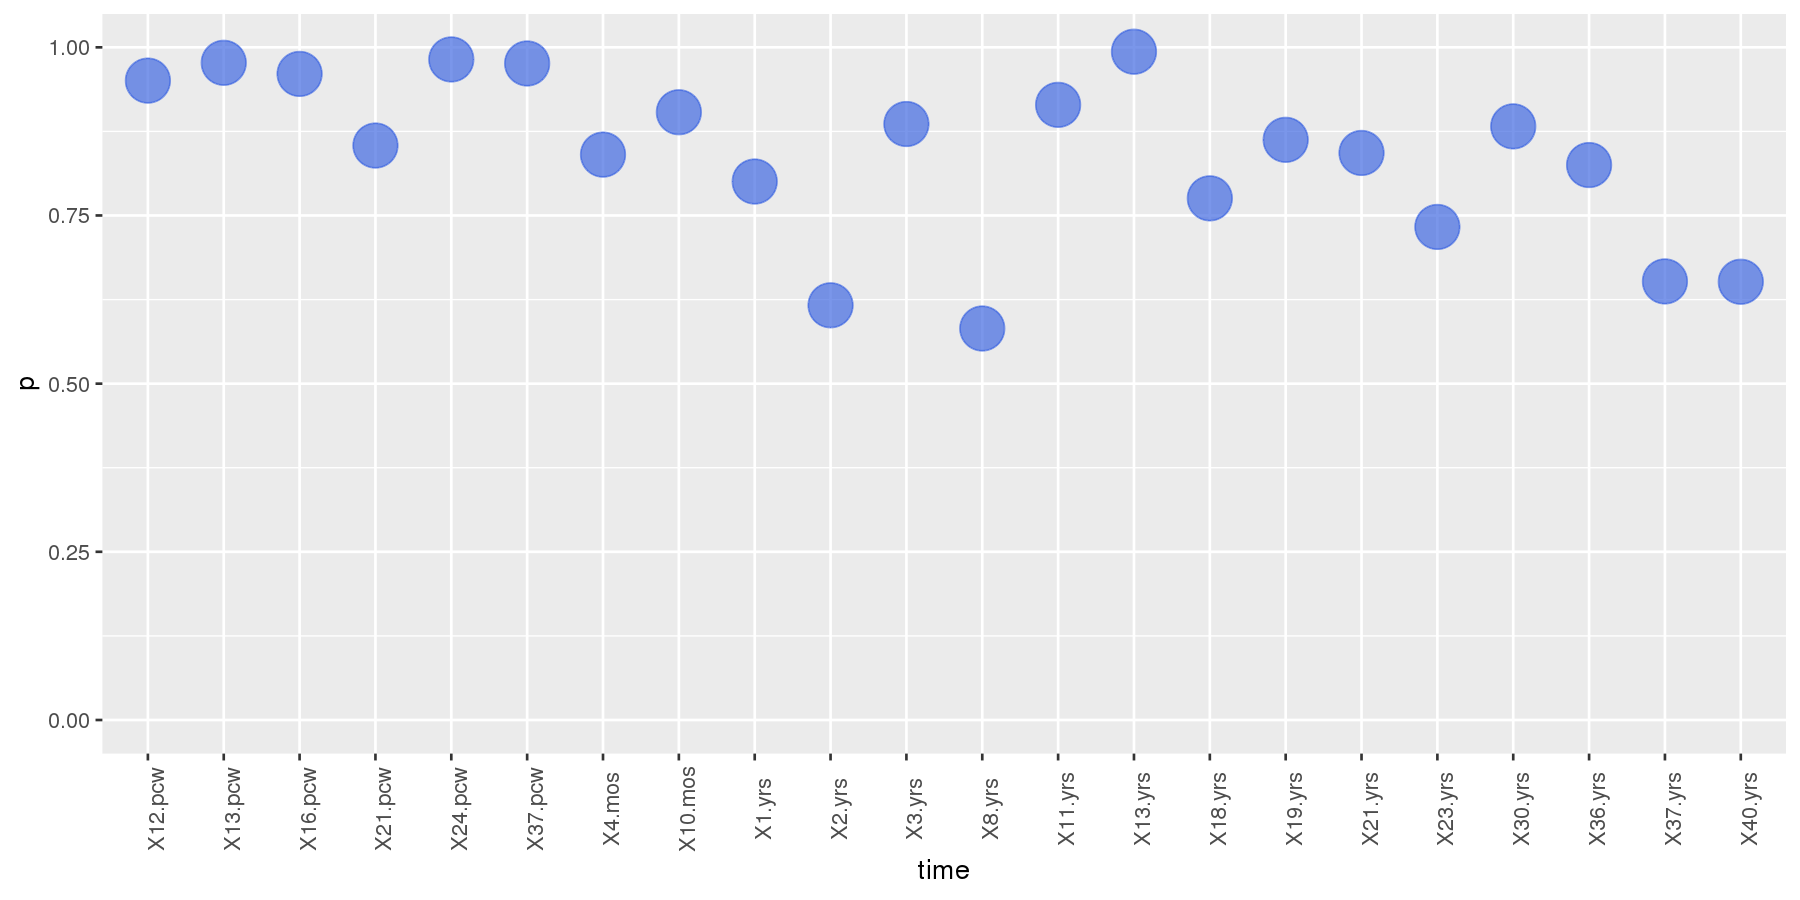

In [1067]:
alan.results$S1C$p.val %>% unlist %>% enframe %>%
    rename('time'='name', 'p' = 'value') %>% mutate_at('time', ~ factor(.x, levels = time.order)) %>%
    arrange(time) %>%
    ggplot() + geom_point(aes(time, p), size = 8, color = 'royalblue', alpha = .7) + 
        ylim(c(0,1)) +
        theme(axis.text.x = element_text(angle = 90))

---
#### STR null distribution & p values

In [1058]:
alan.results$STR$diff.of.means %>% colnames
alan.results$STR$diff.of.means %>% colnames %>% factor(., levels = time.order) %>% order

[1] "X1.yrs"  "X12.pcw" "X13.pcw" "X13.yrs" "X16.pcw" "X17.pcw" "X19.pcw"
 [8] "X19.yrs" "X21.pcw" "X21.yrs" "X23.yrs" "X24.pcw" "X3.yrs"  "X30.yrs"
[15] "X36.yrs" "X37.pcw" "X37.yrs" "X4.mos"  "X4.yrs"  "X40.yrs" "X8.yrs"

[1]  2  3  5  6  7  9 12 16 18  1 13 19 21  4  8 10 11 14 15 17 20

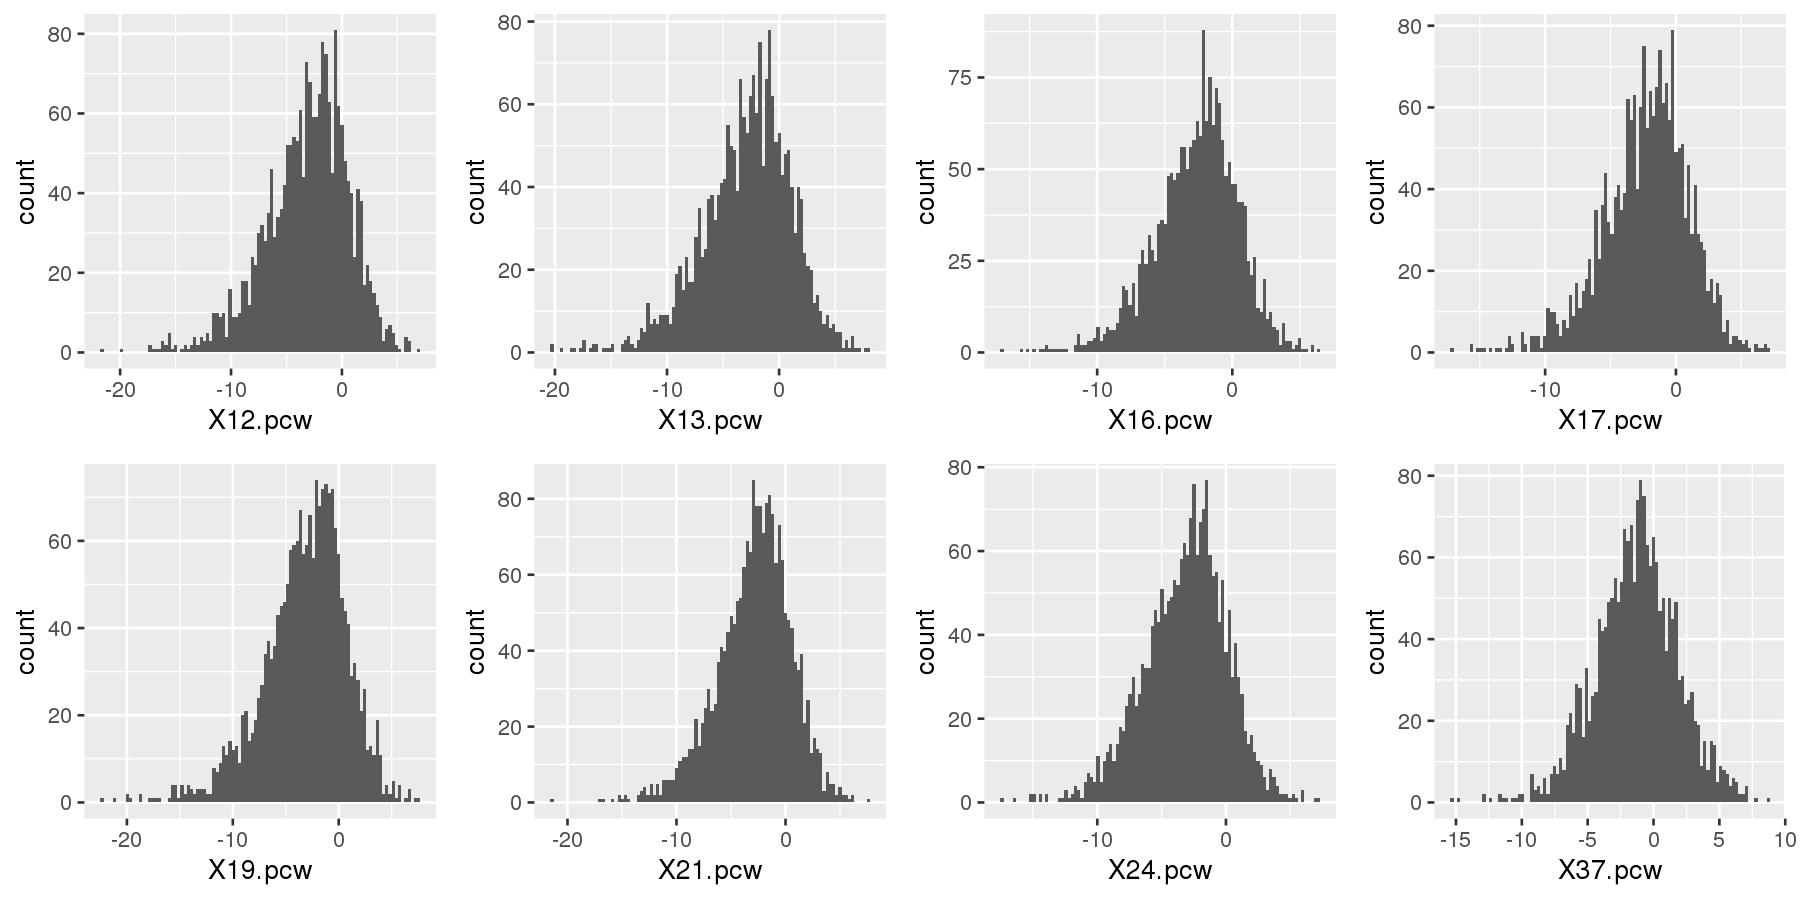

In [1072]:
gridExtra::grid.arrange(grobs = alan.results$STR$histogram[c(2,3,5,6,7,9,12,16)], nrow = 2)

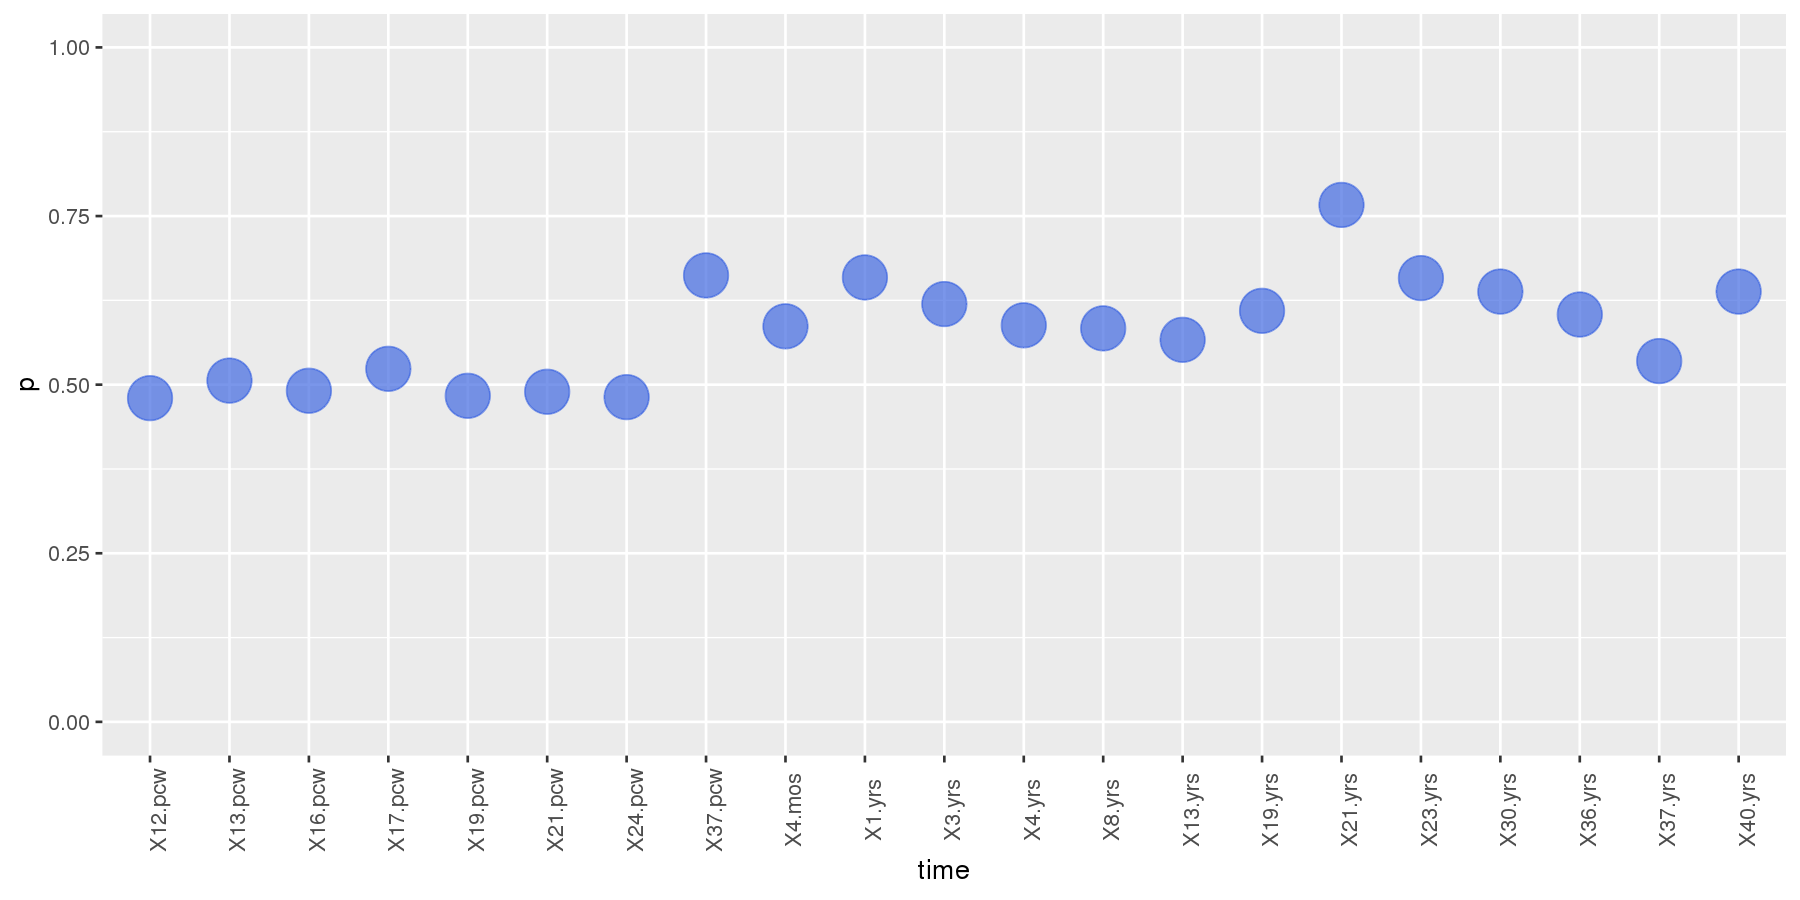

In [1073]:
alan.results$STR$p.val %>% unlist %>% enframe %>%
    rename('time'='name', 'p' = 'value') %>% mutate_at('time', ~ factor(.x, levels = time.order)) %>%
    arrange(time) %>%
    ggplot() + geom_point(aes(time, p), size = 8, color = 'royalblue', alpha = .7) + 
        ylim(c(0,1)) +
        theme(axis.text.x = element_text(angle = 90))

# Estimate distribution of the mean with SIMULATION

population: all TFs.

1. randomly sample 120 TFs, without replacement
2. calculate **`mean`** for each time point
3. resample many times
4. build distribution of the **means**

In [1777]:
sampleMean = function(df, .size = 120) {
    sample_df = sample_n(df, size = .size, replace = F) %>%
                    select(-c('gene_id', 'gene_name', 'screen')) %>%
                    summarise_all(mean)
    return(sample_df)
}

In [1778]:
get.p2 = function(null.dist, obs) {
    # given a distribution: null.dist
    # and an observed value: obs
    # return p value
        if (obs < mean(null.dist)) { # if less than mean, left tail
            p.val = length(null.dist[null.dist <= obs]) / length(null.dist)
            p.val = c('lower.tail' = p.val)
        } else { # otherwise, right tail
            p.val = length(null.dist[null.dist >= obs]) / length(null.dist)
            p.val = c('upper.tail' = p.val)
        }
}

## get p value on cells

In [1788]:
# observed median of hit TFs
obs_mean.cell = filter(tf_norm_median, screen == 'Hit') %>%
                    select(-c('gene_id', 'gene_name', 'screen')) %>%
                    summarise_all(mean)

In [1790]:
obs_mean.cell

ES,H15,D1,D2,D4,D7
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
29.32442,42.77536,38.24389,51.68783,55.47015,62.69505


In [1784]:
set.seed(123)
mean_dist.cell = map_df(1:10000, ~ sampleMean(tf_norm_median))

In [1791]:
head(mean_dist.cell)

,ES,H15,D1,D2,D4,D7
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,31.80612,30.17421,33.56032,42.57360,49.32518,50.83424
2,65.63915,66.97058,65.02363,65.51289,60.67582,59.80312
3,81.35632,82.25988,96.56443,70.73664,59.39756,75.38888
4,26.59383,30.95042,31.65949,39.50209,42.39748,48.34187
5,37.66083,43.71977,43.61671,55.47102,54.46018,58.41772
6,45.14244,47.36195,47.12161,54.07170,49.56515,49.00515


In [1800]:
hist3 = map2(colnames(mean_dist.cell), obs_mean.cell, ~ ggplot(mean_dist.cell) + 
        geom_histogram(aes_string(x = .x), binwidth = .5) + coord_cartesian(xlim = c(0, 150), ylim = c(0, 200)) +
        geom_vline(xintercept = .y, color = 'red')  +
        theme_classic())

In [1796]:
# one.sided p values
pvals.cell = map2(mean_dist.cell, obs_mean.cell, ~ get.p2(.x, .y)) %>% unlist %>% enframe %>% # get p.value
                mutate(time = str_extract(name, '^[A-Z1-9]+')) %>% # correct names
                mutate_at('name', ~ str_extract(.x, '(lower.tail)|(upper.tail)')) %>%
                rename(p = value, side = name) %>%
                mutate_at('time', ~ factor(.x, levels = c('ES', 'H15', 'D1','D2','D4','D7')))

In [1899]:
pvals.cell

side,p,time
<chr>,<dbl>,<fct>
lower.tail,0.0054,ES
lower.tail,0.1649,H15
lower.tail,0.0647,D1
lower.tail,0.2763,D2
lower.tail,0.5508,D4
lower.tail,0.6973,D7


In [1813]:
obs_mean.cell

ES,H15,D1,D2,D4,D7
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
29.32442,42.77536,38.24389,51.68783,55.47015,62.69505


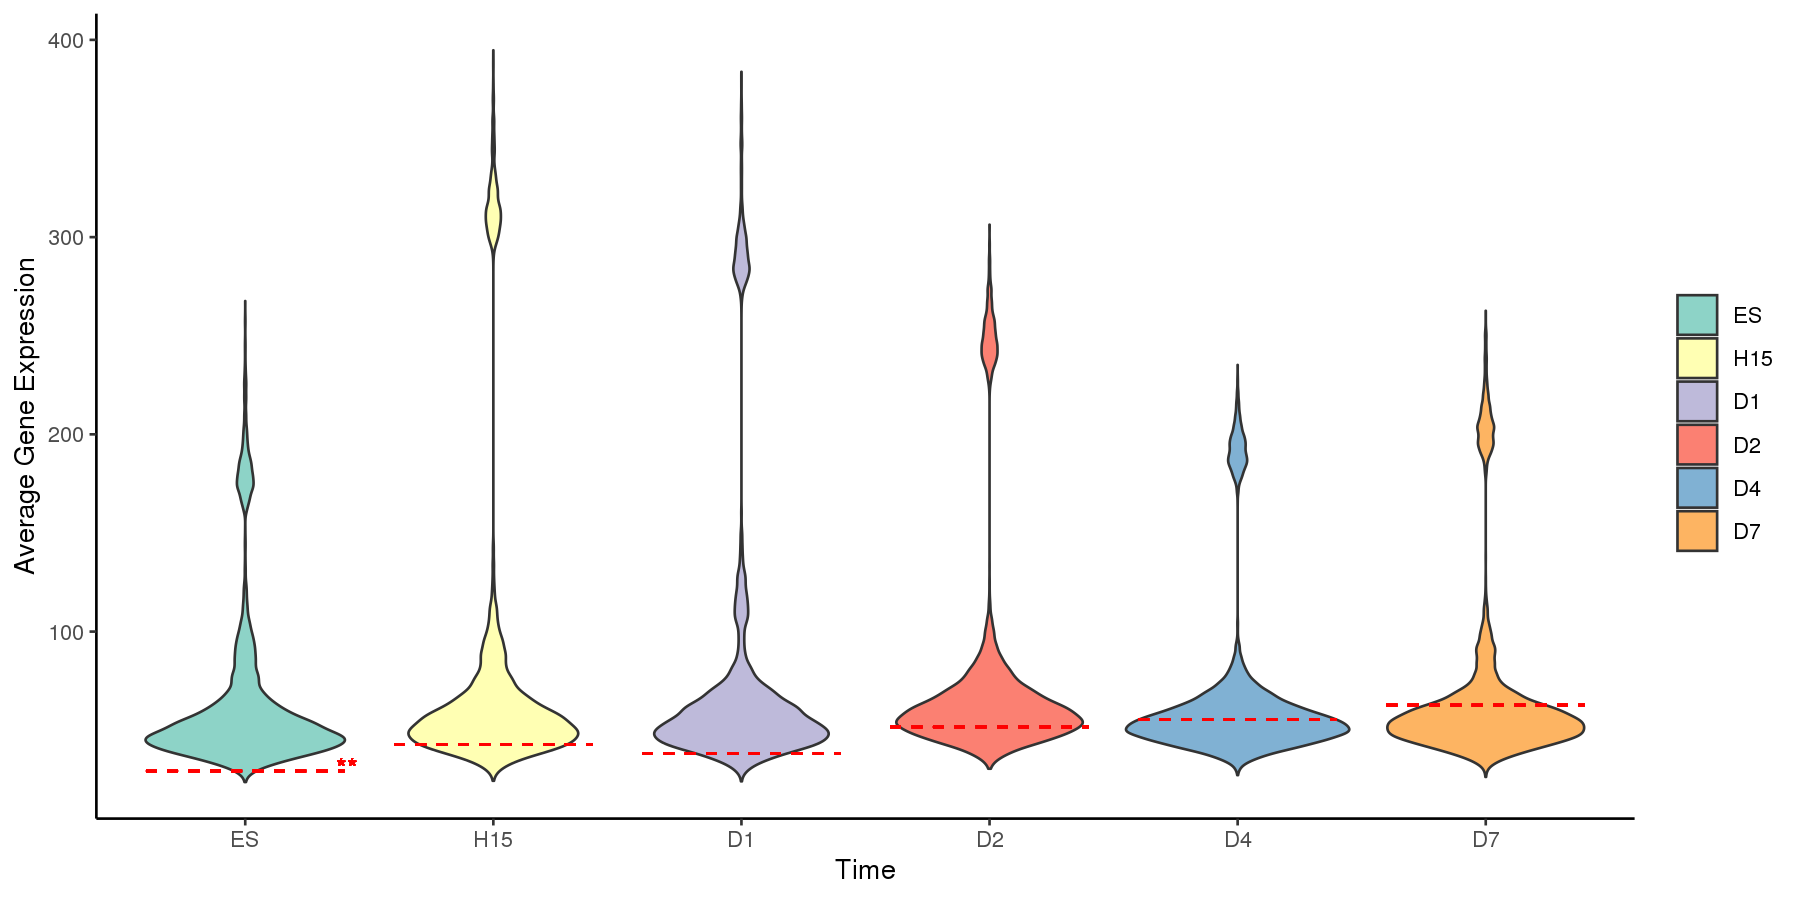

In [1943]:
# violin plot
#pdf(file = 'figures/sig_test_by_mean_cell_violin.pdf', width = 8, height = 11)
pivot_longer(mean_dist.cell, cols = everything(), names_to = "time", values_to = "mean_expr") %>%
    mutate_at('time', ~ factor(.x, levels = c('ES', 'H15', 'D1', 'D2', 'D4','D7'))) %>%
    ggplot() + geom_violin(aes(x = time, y = mean_expr, fill = time)) +
        scale_fill_brewer(palette = 'Set3') +
        labs(x = "Time", y = "Average Gene Expression") +
        geom_segment(aes(x = .6, y = 29.32, xend = 1.4, yend = 29.32), color = 'red', alpha = .5, linetype = 'dashed') + # ES observed
        geom_segment(aes(x = 1.6, y = 42.78, xend = 2.4, yend = 42.78), color = 'red', alpha = .5, linetype = 'dashed') + # H15
        geom_segment(aes(x = 2.6, y = 38.24, xend = 3.4, yend = 38.24), color = 'red', alpha = .5, linetype = 'dashed') + # D1
        geom_segment(aes(x = 3.6, y = 51.69, xend = 4.4, yend = 51.69), color = 'red', alpha = .5, linetype = 'dashed') + # D2
        geom_segment(aes(x = 4.6, y = 55.47, xend = 5.4, yend = 55.47), color = 'red', alpha = .5, linetype = 'dashed') + # D4
        geom_segment(aes(x = 5.6, y = 62.70, xend = 6.4, yend = 62.70), color = 'red', alpha = .5, linetype = 'dashed') + # D7 
        geom_text(aes(x = 1.41, y = 31, label = '**'), color = 'red') +
        theme_classic() +
        theme(legend.title = element_blank())
#dev.off()

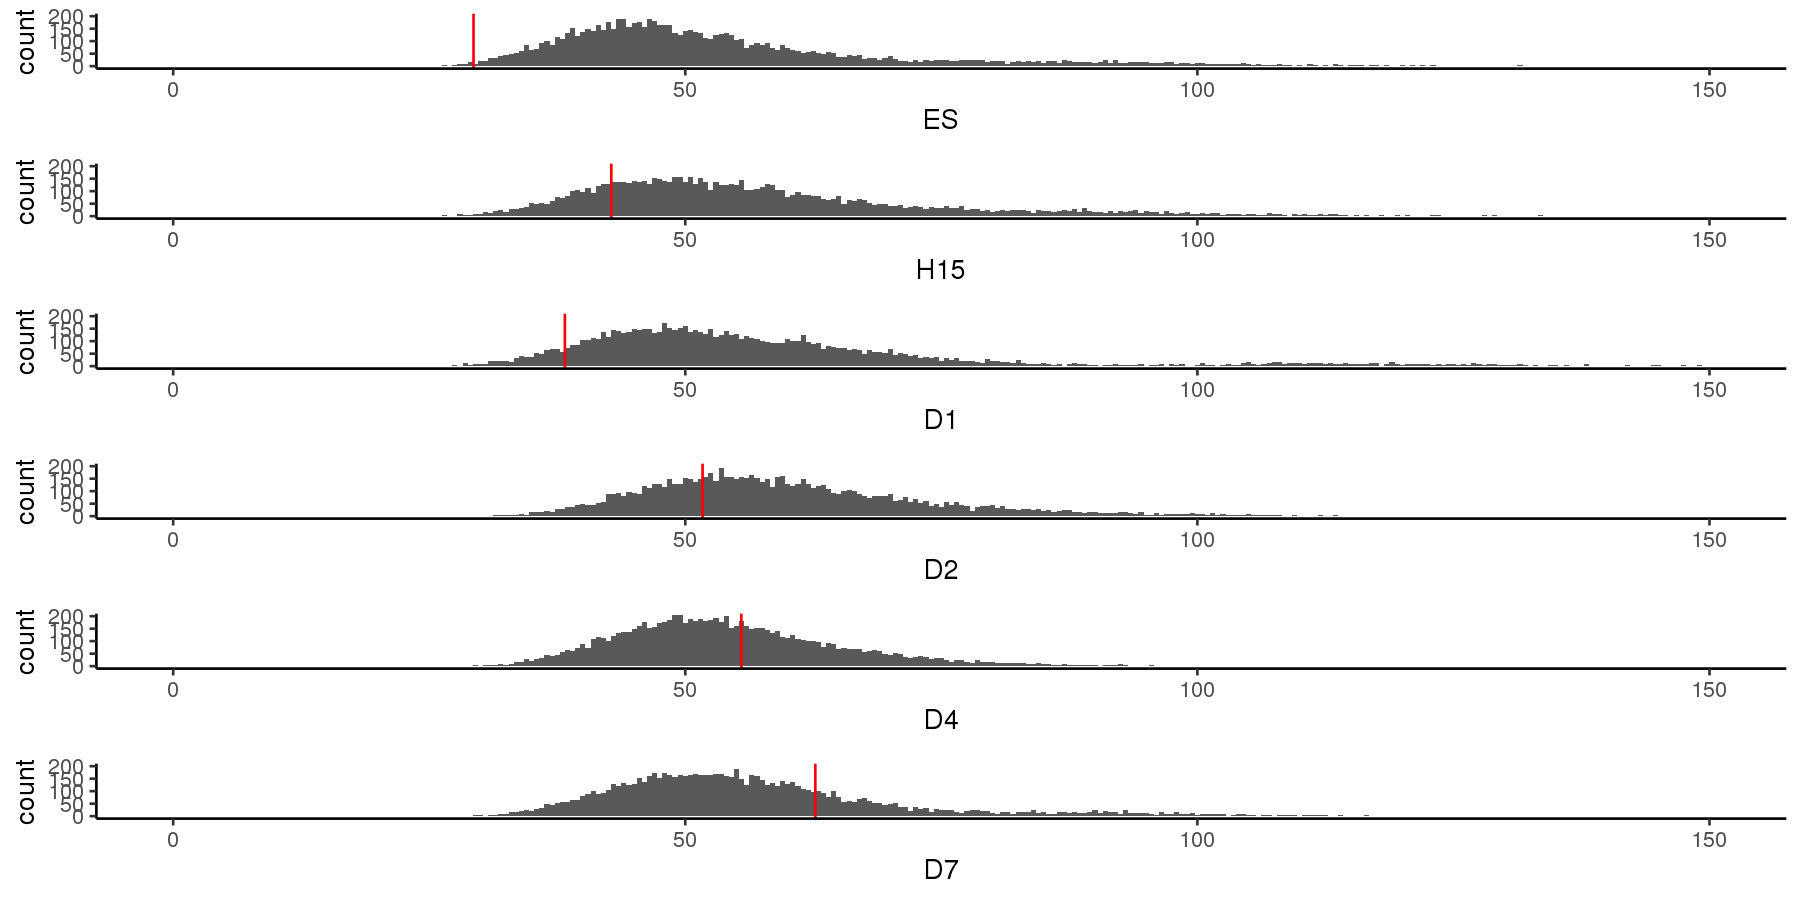

In [1940]:
#pdf(file = 'figures/sig_test_by_mean_cell_histogram.pdf', width = 8, height = 11)
gridExtra::grid.arrange(grobs = hist3, nrow = 6)
#dev.off()

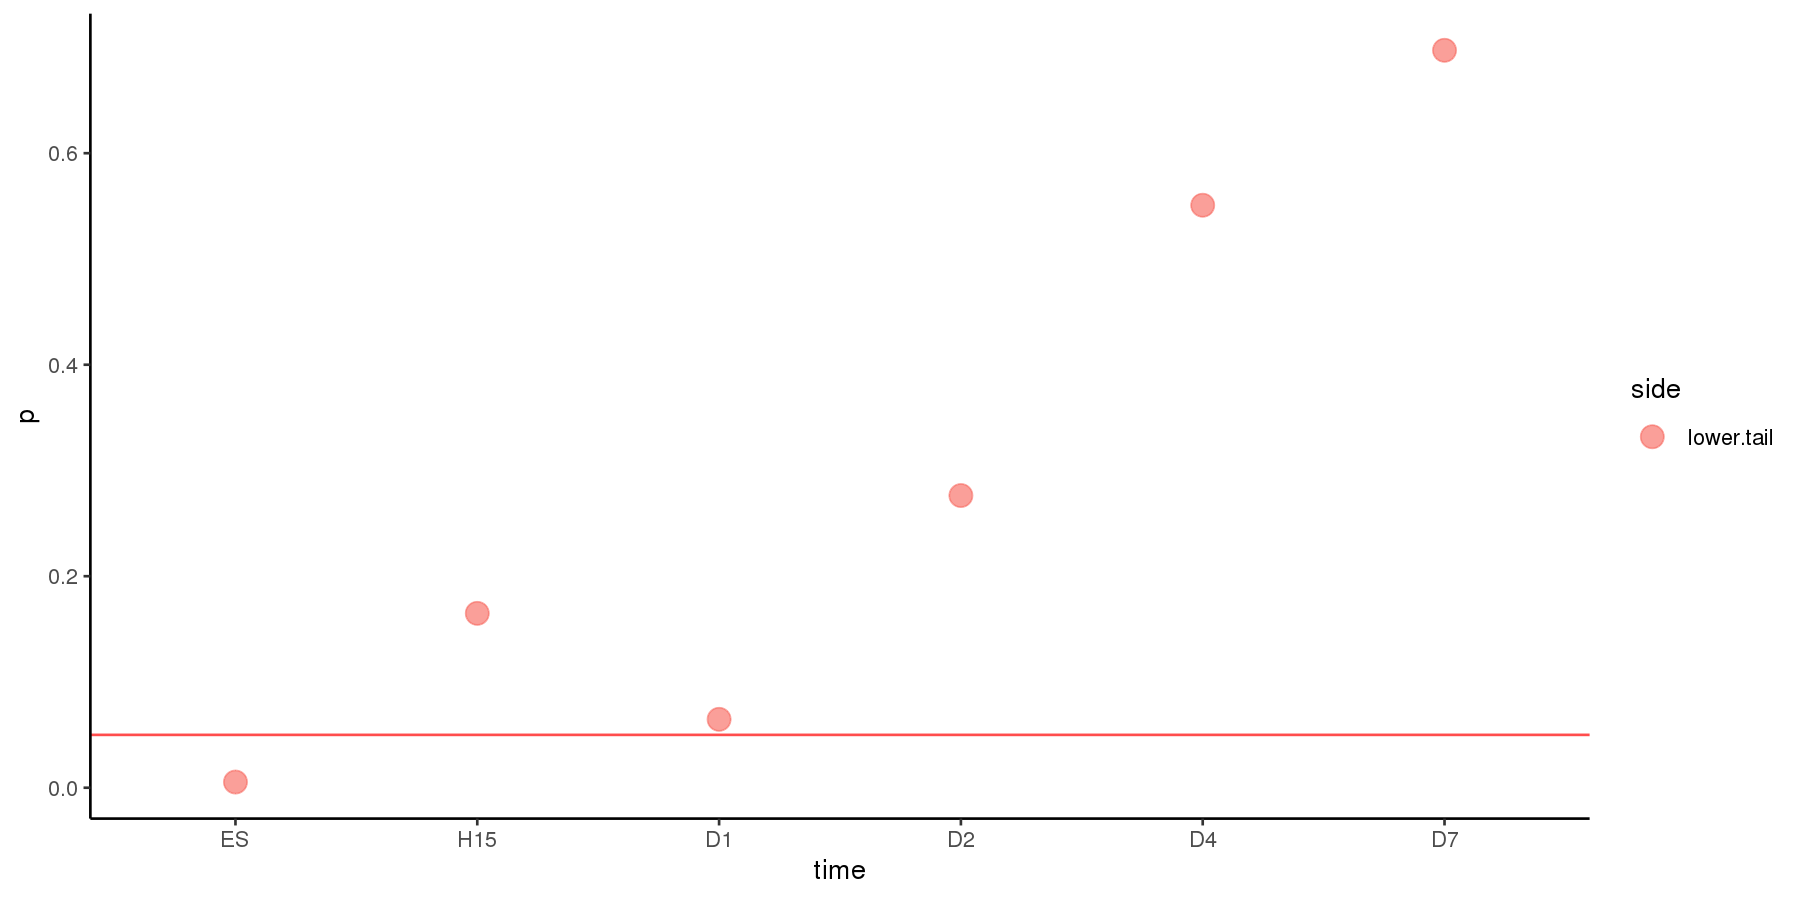

In [1916]:
ggplot(pvals.cell) + geom_point(aes(time, p, color = side), size = 4, alpha = .7) + 
    geom_hline(yintercept = .05, color = 'red', alpha = .7) +
    theme_classic()

<br><br>

---

## get p value on Allen Brain Map

In [1919]:
sampleMean

function(df, .size = 120) {
    sample_df = sample_n(df, size = .size, replace = F) %>%
                    select(-c('gene_id', 'gene_name', 'screen')) %>%
                    summarise_all(mean)
    return(sample_df)
}
<bytecode: 0x24887fe0>

In [1921]:
head(mean_dist.cell)

,ES,H15,D1,D2,D4,D7
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,31.80612,30.17421,33.56032,42.57360,49.32518,50.83424
2,65.63915,66.97058,65.02363,65.51289,60.67582,59.80312
3,81.35632,82.25988,96.56443,70.73664,59.39756,75.38888
4,26.59383,30.95042,31.65949,39.50209,42.39748,48.34187
5,37.66083,43.71977,43.61671,55.47102,54.46018,58.41772
6,45.14244,47.36195,47.12161,54.07170,49.56515,49.00515


In [1938]:
map(brain_tf, colnames) %>% flatten %>% unlist %>% unique %>% .[str_detect(., 'yrs')]

[1] "X1.yrs"  "X11.yrs" "X13.yrs" "X15.yrs" "X18.yrs" "X19.yrs" "X2.yrs" 
 [8] "X21.yrs" "X23.yrs" "X3.yrs"  "X30.yrs" "X36.yrs" "X37.yrs" "X4.yrs" 
[15] "X40.yrs" "X8.yrs"

pcw_stage1: pcw 1 - 13
pcw_stage2: pcw 14 - 26
pcw_stage3: pcw 27 - 40
toddler: 1 mos - 6 yrs
teen: 7 yrs - 17 yrs
adult: 18 yrs - 


In [1924]:
# mean distribution for all 4 brain structures
tic()
set.seed(123)
mean_dist.brain.list = lapply(brain_tf, function(d) map_df(1:10000, ~sampleMean(df = d)))
toc()

In [1564]:
# observed median of hits for all 4 brain structures
obs_mean.brain.list = lapply(brain_tf, function(d) {
                                filter(d, screen == 'Hit') %>%
                                select(-c('gene_id', 'gene_name', 'screen')) %>%
                                summarise_all(mean)
})

In [1640]:
pvals.brain.list  = list()
hist3.list = list()
for (struc in names(brain_tf)) {
    nulls3 = median_dist.brain.list[[struc]]
    obs3 = obs_medians.brain.list[[struc]]
    hist3 = map2(names(nulls3), obs3, ~ ggplot(nulls3) + geom_histogram(aes_string(x = .x), bins = 100, alpha = .5) + 
                    geom_vline(xintercept = .y, color = 'red', alpha = .7) + theme_classic())
    pvals3 = map2(nulls3, obs3, ~get.p2(.x, obs = .y)) %>% unlist %>% enframe %>%
                 mutate(time = str_extract(name, '^[a-zA-Z0-9]+\\.[a-zA-Z0-9]+')) %>%
                 mutate_at('name', ~ str_extract(.x, '(lower.tail)|(upper.tail)')) %>%
                 rename(p = value, side = name)
    pvals.brain.list[[struc]] = pvals3
    hist3.list[[struc]] = hist3
}

#### CBC median distribution & p-values

In [1669]:
which(str_detect(names(median_dist.brain.list$CBC), 'mos'))

[1]  2 22

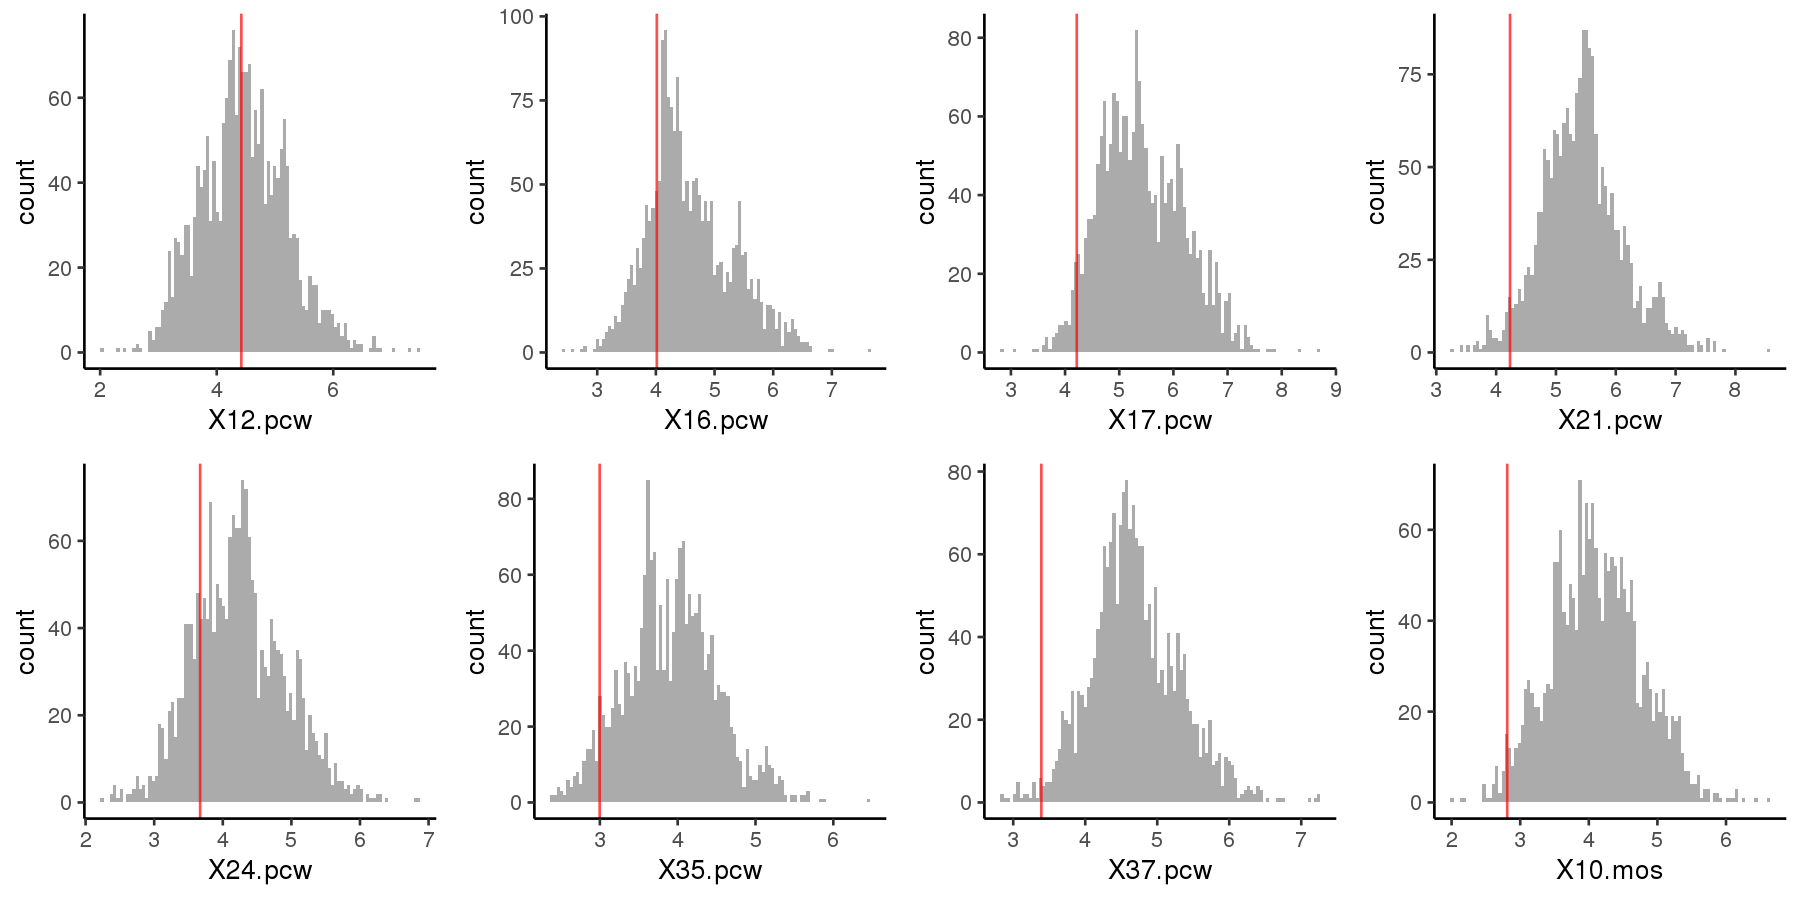

In [1670]:
gridExtra::grid.arrange(grobs = hist3.list[['CBC']][c(4,7,8,12,15,18,20,2)], nrow = 2)

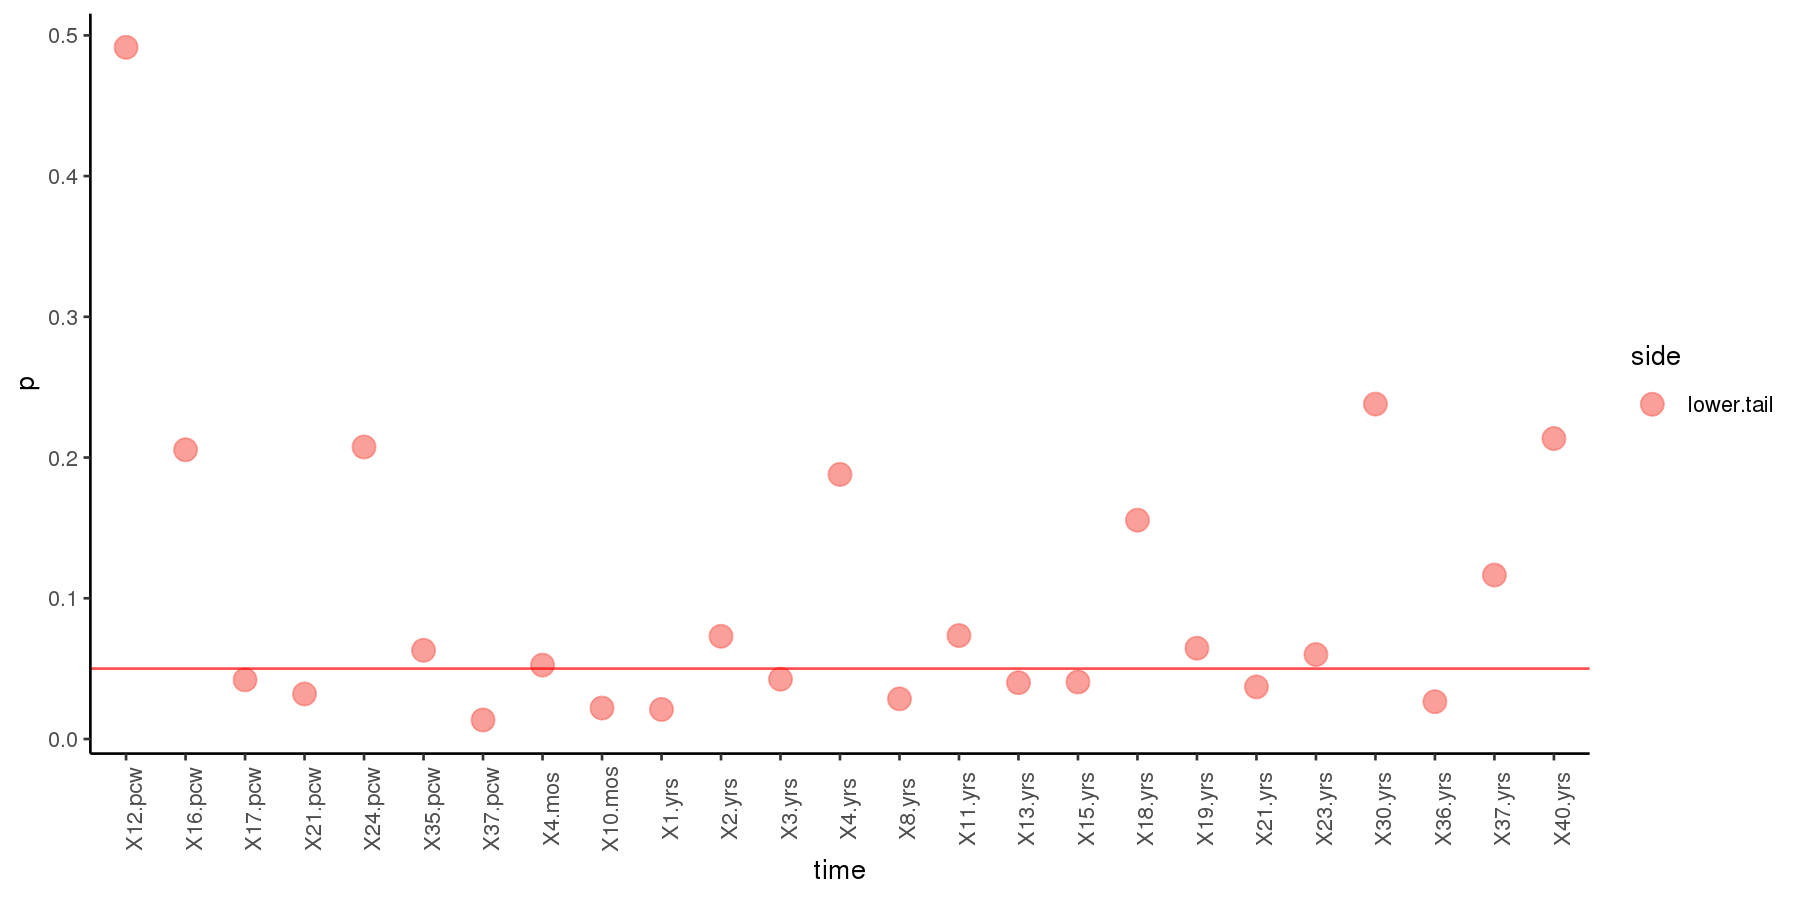

In [1654]:
mutate_at(pvals.brain.list$CBC, 'time', ~ factor(.x, time.order)) %>%
    ggplot() + geom_point(aes(time, p, color = side), size = 4, alpha = .7) + 
    geom_hline(yintercept = .05, color = 'red', alpha = .7) + 
    theme_classic() + 
    theme(axis.text.x = element_text(angle = 90))

#### DFC median distribution & p-values

In [1671]:
which(str_detect(names(median_dist.brain.list$DFC), 'pcw'))

[1]  4  5  7  8 10 13 15 16 20 25 27

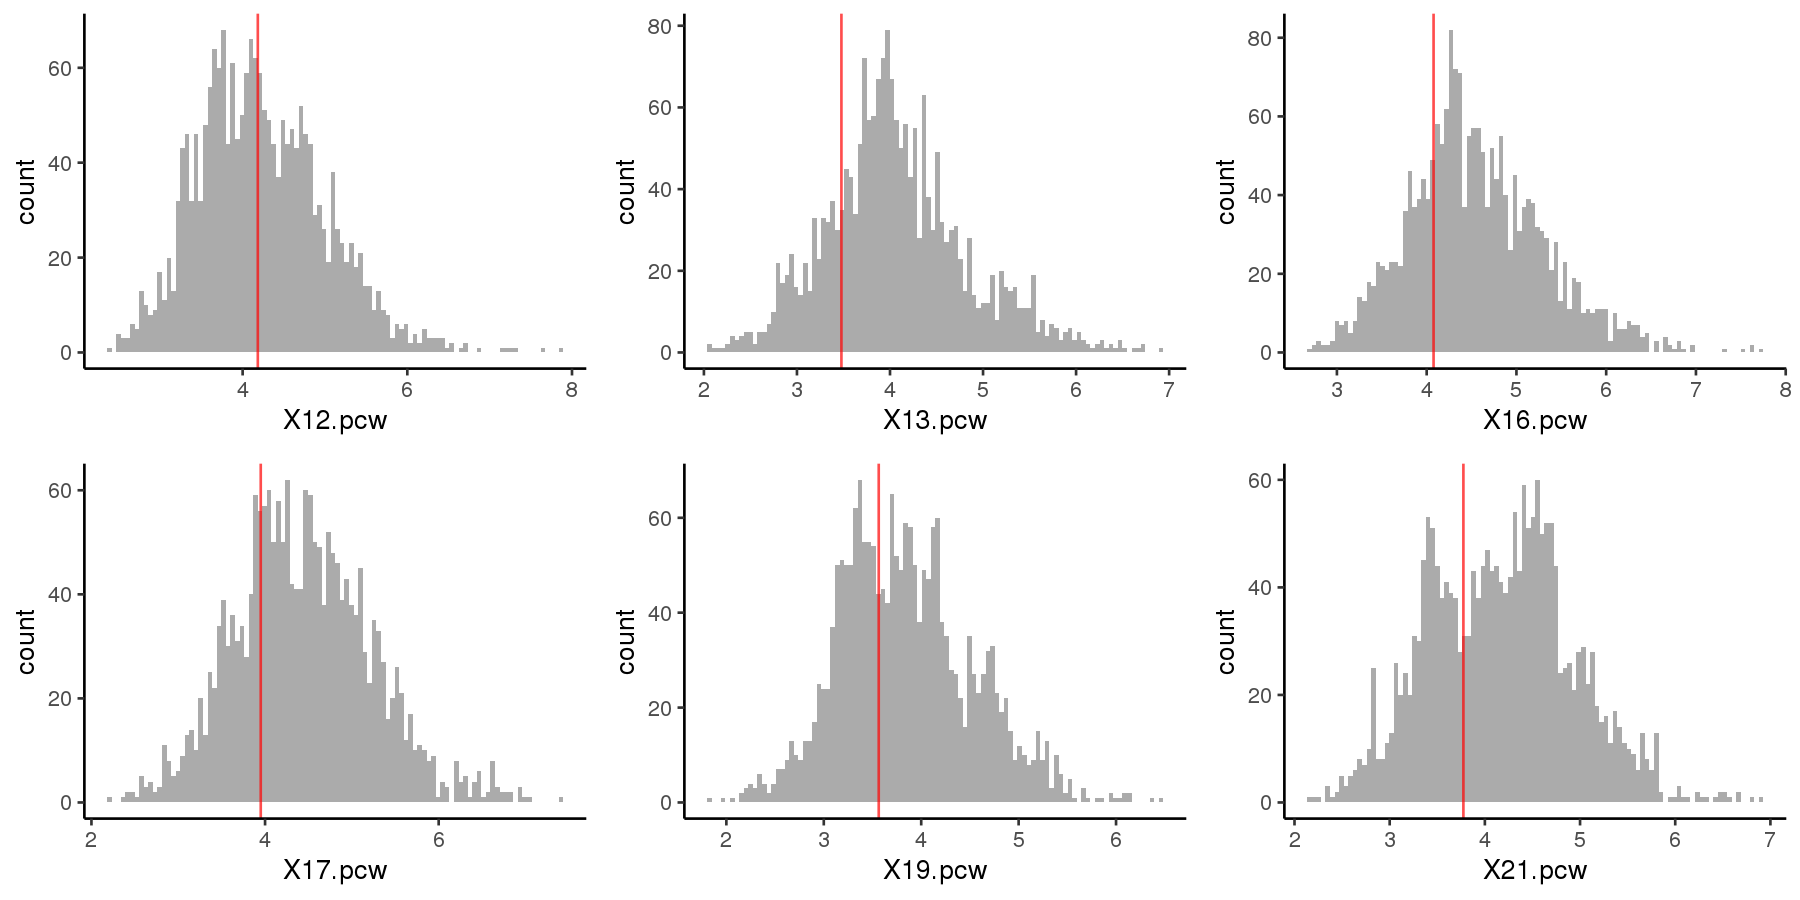

In [1672]:
gridExtra::grid.arrange(grobs = hist3.list[['DFC']][c(4,5,7,8,10,13)], nrow = 2)

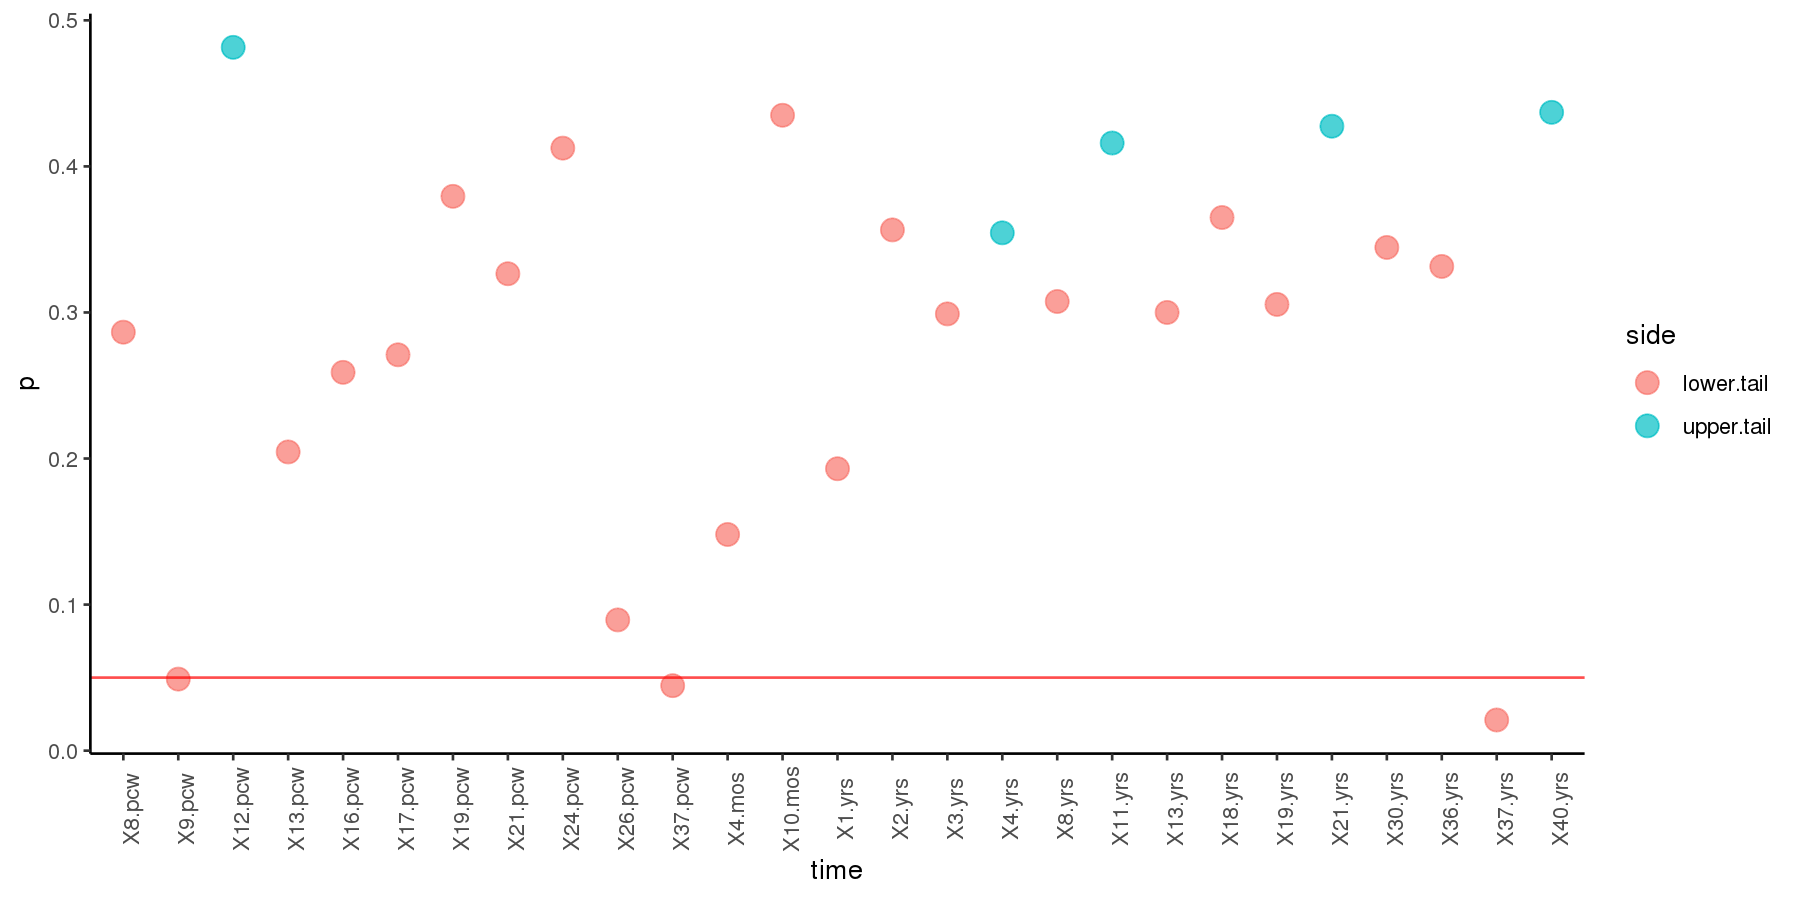

In [1673]:
mutate_at(pvals.brain.list$DFC, 'time', ~ factor(.x, time.order)) %>%
    ggplot() + geom_point(aes(time, p, color = side), size = 4, alpha = .7) + 
    geom_hline(yintercept = .05, color = 'red', alpha = .7) + 
    theme_classic() + 
    theme(axis.text.x = element_text(angle = 90))

#### S1C median distribution & p-values

In [1674]:
which(str_detect(names(median_dist.brain.list$S1C), 'pcw'))

[1]  4  5  7 11 14 18

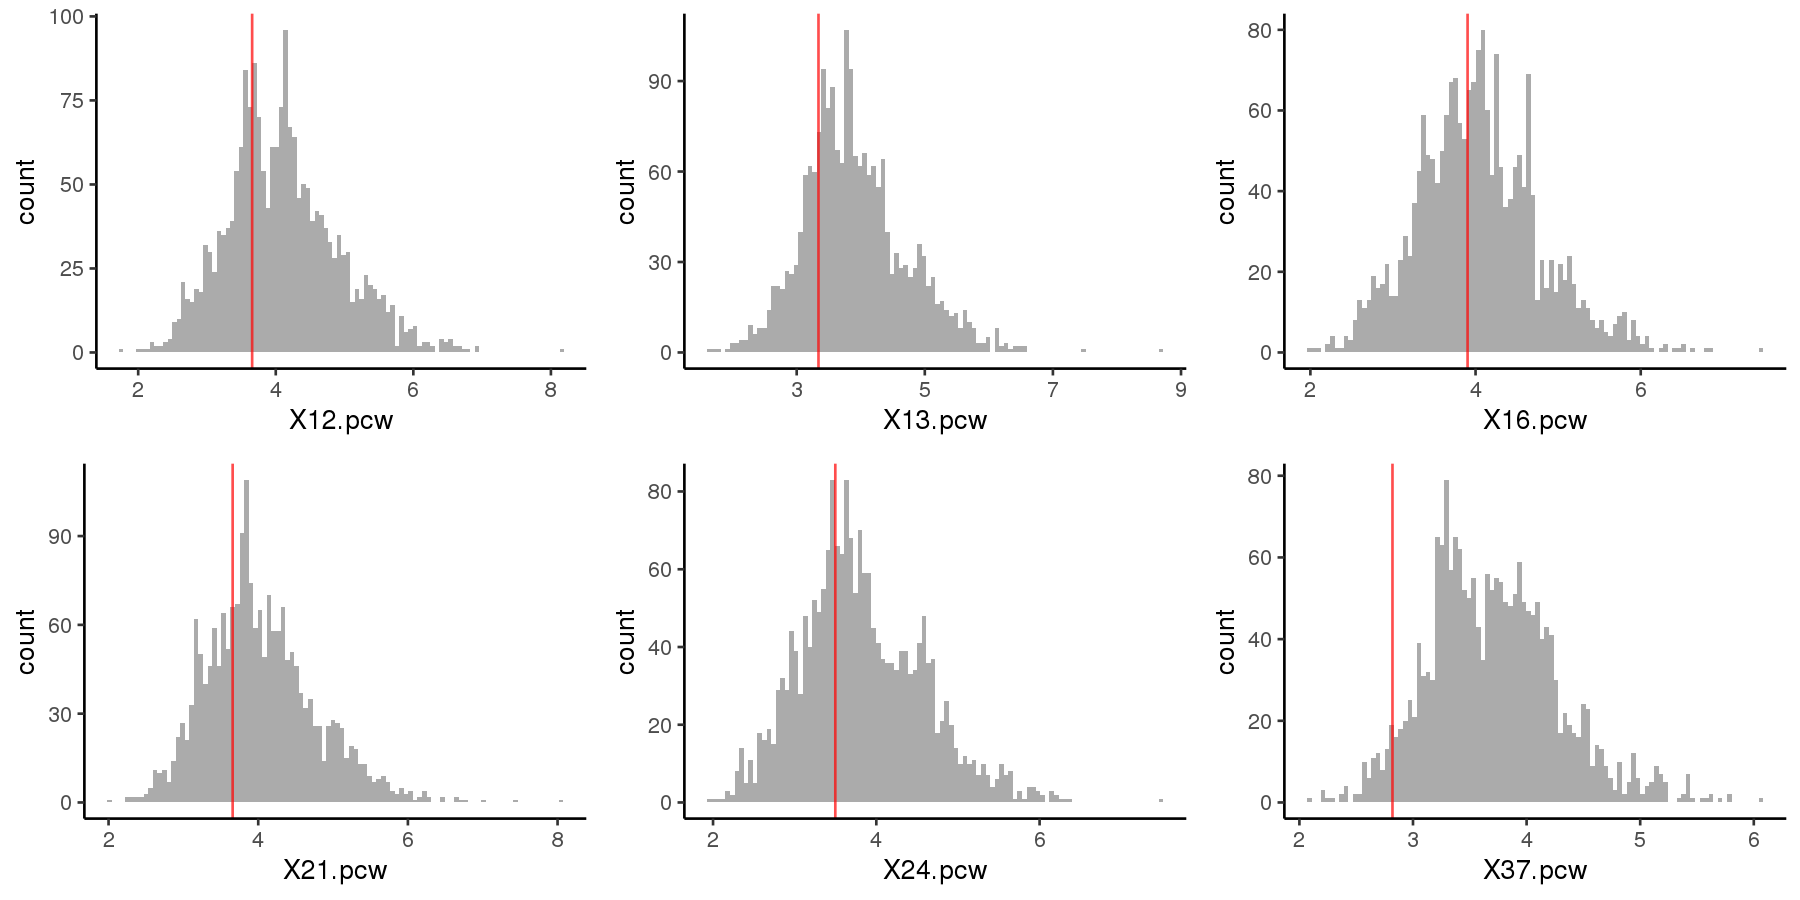

In [1676]:
gridExtra::grid.arrange(grobs = hist3.list[['S1C']][c(4,5,7,11,14,18)], nrow = 2)

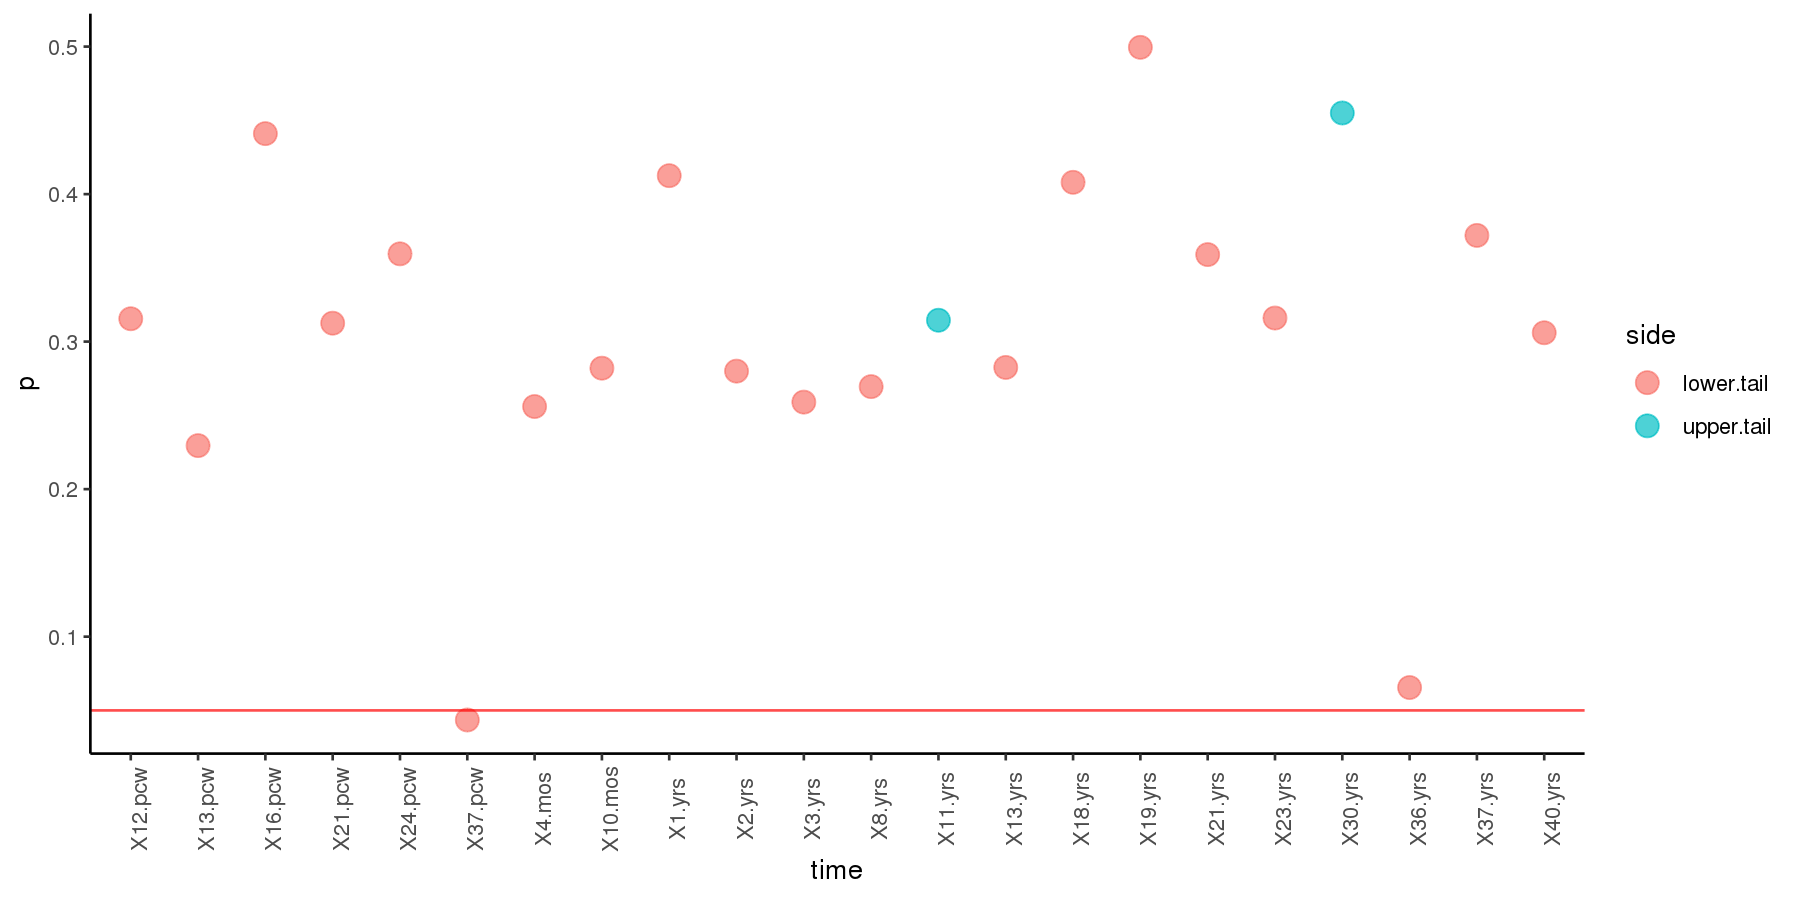

In [1677]:
mutate_at(pvals.brain.list$S1C, 'time', ~ factor(.x, time.order)) %>%
    ggplot() + geom_point(aes(time, p, color = side), size = 4, alpha = .7) + 
    geom_hline(yintercept = .05, color = 'red', alpha = .7) + 
    theme_classic() + 
    theme(axis.text.x = element_text(angle = 90))

#### STR median distribution & p-values

In [1683]:
which(str_detect(names(median_dist.brain.list$STR), 'pcw'))

[1]  2  3  5  6  7  9 12 16

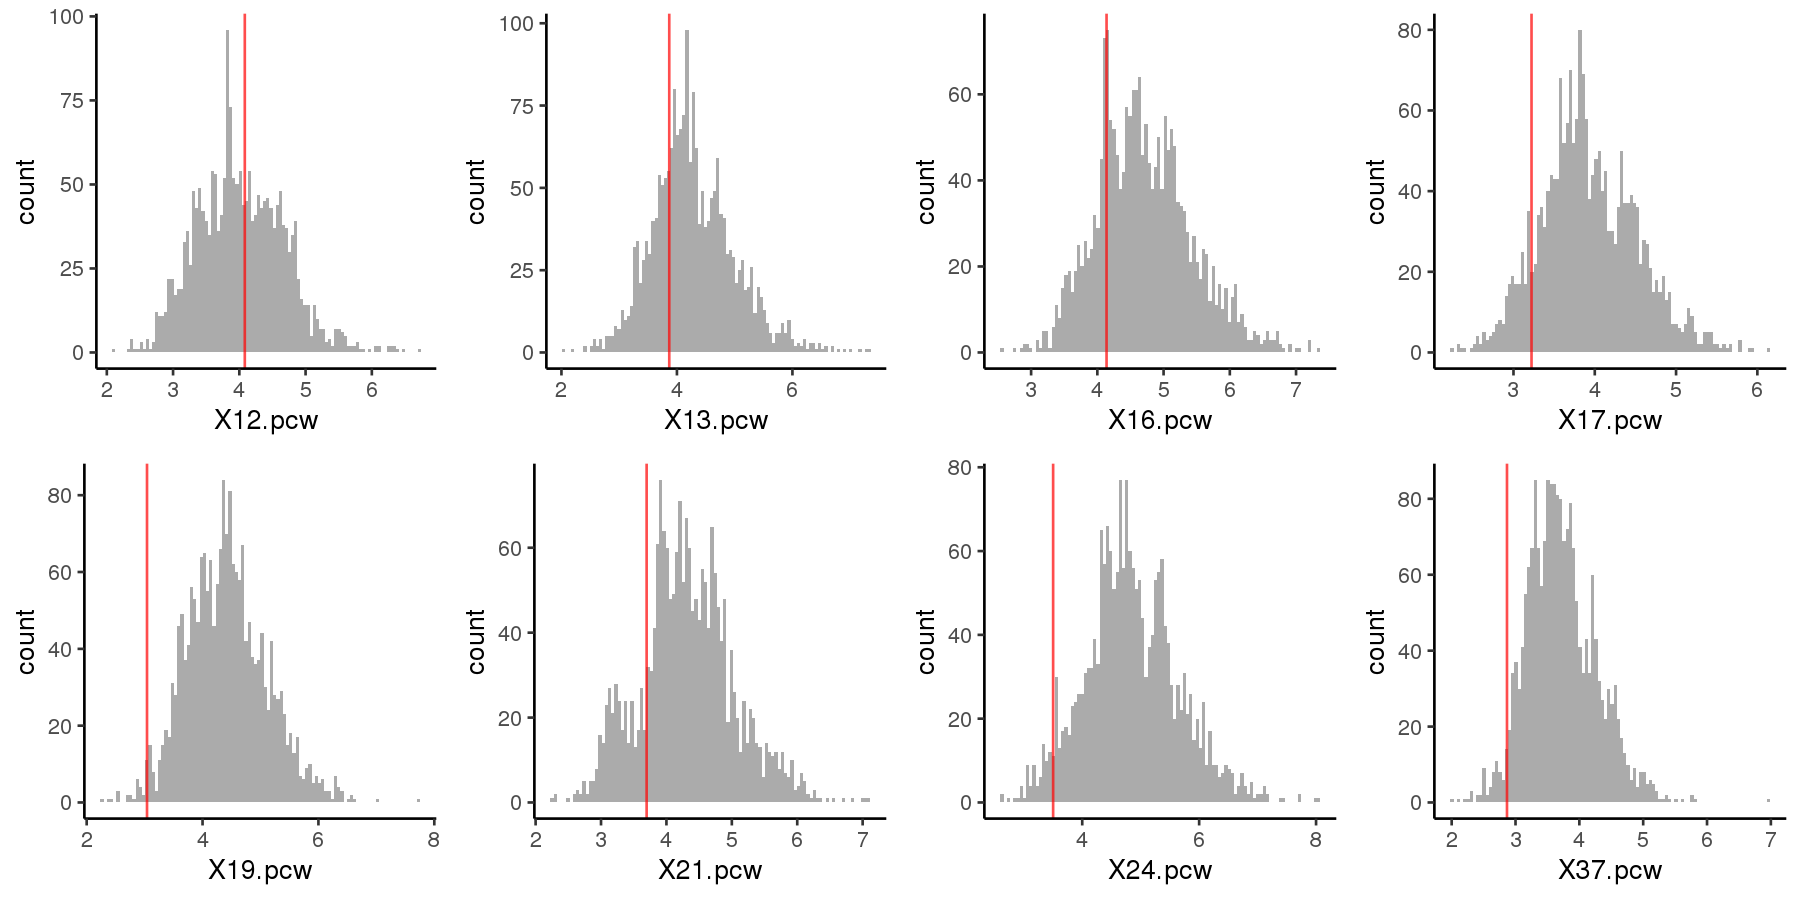

In [1685]:
gridExtra::grid.arrange(grobs = hist3.list[['STR']][c(2,3,5,6,7,9,12,16)], nrow = 2)

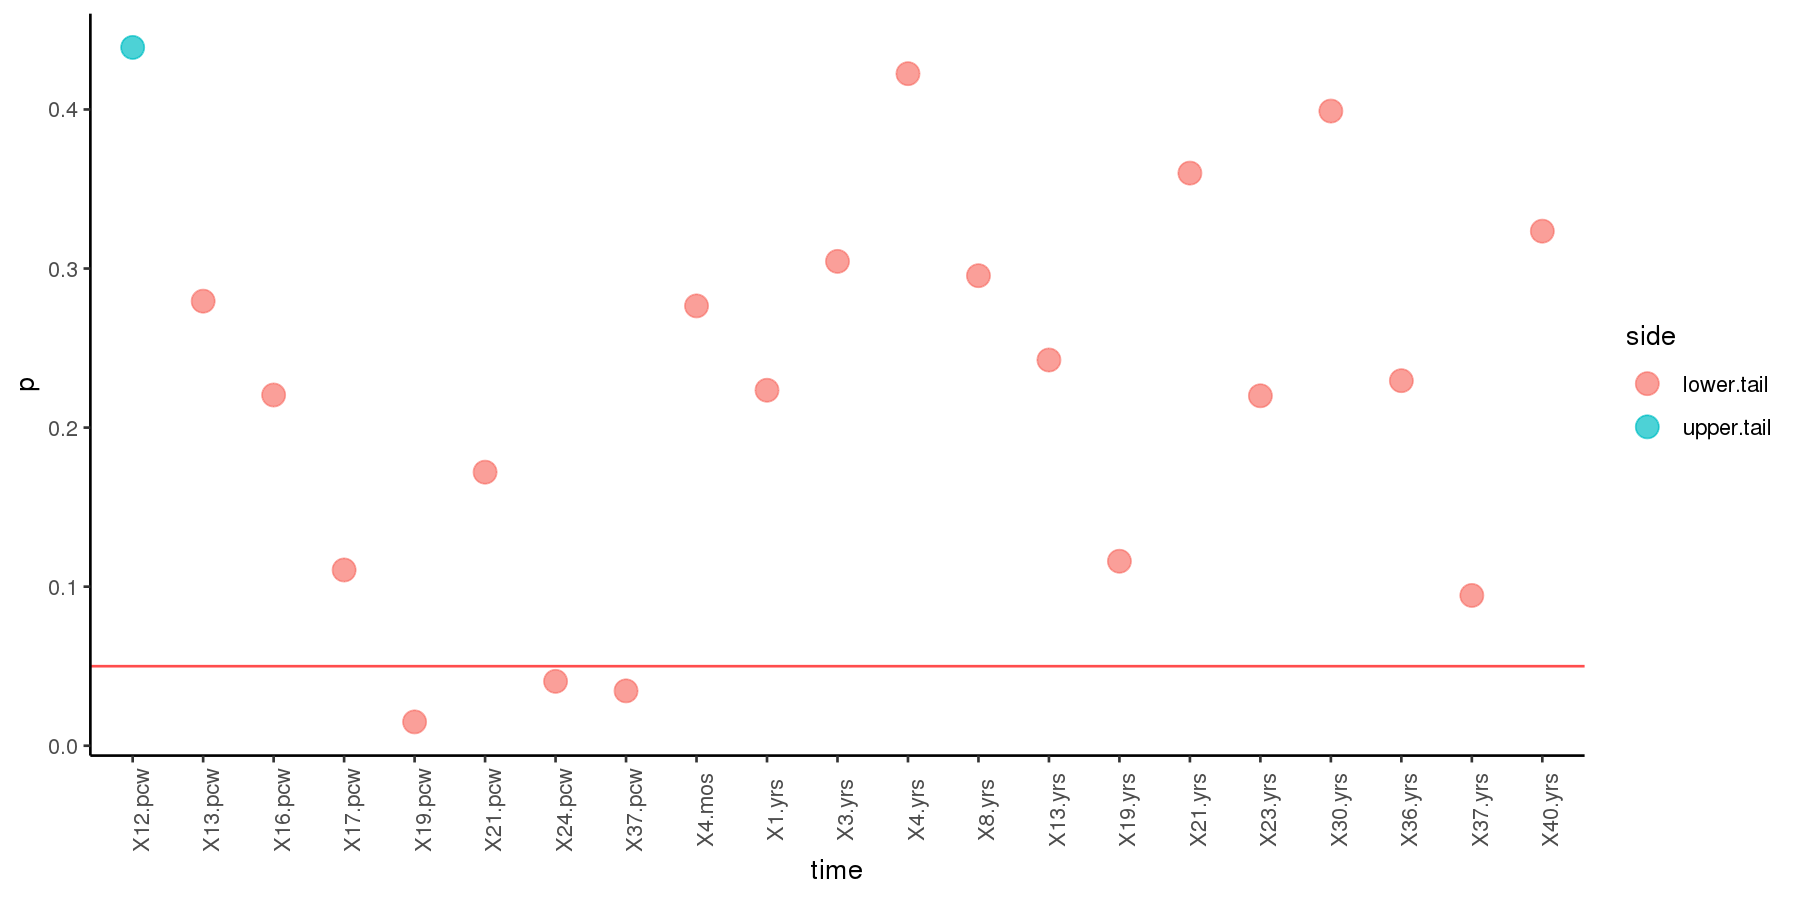

In [1680]:
mutate_at(pvals.brain.list$STR, 'time', ~ factor(.x, time.order)) %>%
    ggplot() + geom_point(aes(time, p, color = side), size = 4, alpha = .7) + 
    geom_hline(yintercept = .05, color = 'red', alpha = .7) + 
    theme_classic() + 
    theme(axis.text.x = element_text(angle = 90))

<br><br><br>

---

# Hits expression

### Cell

In [1380]:
cell_hits_expr = select(tf_norm_median, screen:D7) %>%
                        filter(screen == 'Hit') %>% 
                        group_by(screen) %>%
                        summarise_all(sum) %>%
                        add_column(expmt = 'Cell') %>%
                        pivot_longer(cols = 2:7, names_to = 'time', values_to = 'rpm') %>%
                        mutate_at('time', ~ factor(.x, levels = c('ES', 'H15', 'D1', 'D2', 'D4', 'D7')))

In [1381]:
cell_hits_expr

screen,expmt,time,rpm
<fct>,<chr>,<fct>,<dbl>
Hit,Cell,ES,2873.793
Hit,Cell,H15,4191.985
Hit,Cell,D1,3747.901
Hit,Cell,D2,5065.408
Hit,Cell,D4,5436.075
Hit,Cell,D7,6144.115


In [1944]:
gg_hits_expr1 = ggplot(cell_hits_expr) + geom_line(aes(time, rpm, group = expmt)) +
    labs(x = 'Time', y = 'RPM', title = 'Hit genes expression - Cells') +
    theme_classic() +
    theme(plot.margin = margin(0, 15, 0, 0, "cm"))

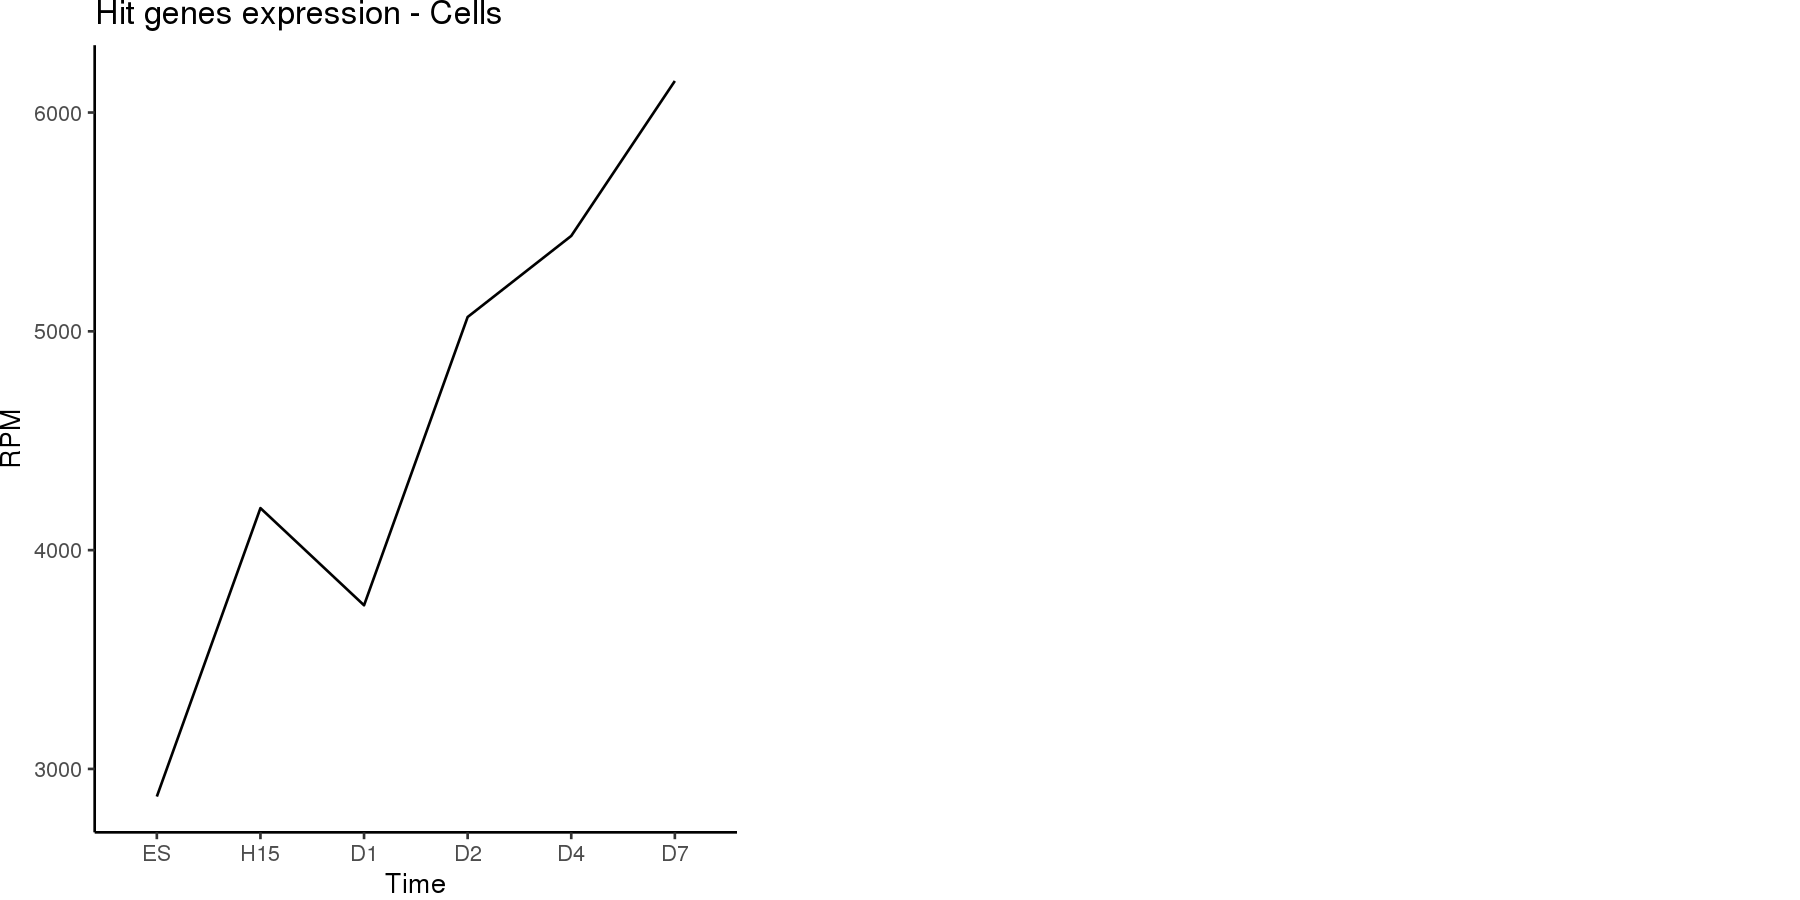

In [1945]:
gg_hits_expr1

### box plot

In [2225]:
pdf('figures/RNAseq_hit_expr_boxplot.pdf', height = 11, width = 8)
filter(tf_norm_median, screen == 'Hit') %>%
    select(gene_id, ES:D7) %>%
    pivot_longer(cols = ES:D7, names_to = 'time', values_to = 'RPM') %>%
    mutate_at('time', ~ factor(.x, levels = c('ES', 'H15', paste0('D', c(1,2,4,7))))) %>% 
    ggplot() + stat_boxplot(aes(time, RPM, color = time), geom = "errorbar", width = 0.5) + 
        geom_boxplot(aes(time, RPM, color = time), outlier.shape = NA, notch = F) + 
        geom_point(aes(time, RPM), size = .5, alpha = .2, position = 'jitter') +
        ylim(c(0,100)) +
        scale_color_brewer(palette = "Dark2", breaks = NULL) +
        theme_classic()
dev.off()

Warning message:
“Removed 65 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 65 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 102 rows containing missing values (geom_point).”


png 
  2

### Allen Brain map

In [1324]:
brain_hits_expr = imap_dfr(brain_tf, ~ select(.x, -gene_id, -gene_name) %>%
                        filter(screen == 'Hit') %>% 
                        group_by(screen) %>%
                        summarise_all(sum) %>% # summarise expression on all hits
                        add_column(structure = .y) %>%
                        pivot_longer(cols = starts_with("X"), names_to = "time", values_to = "rpkm") %>% # transpose
                        mutate_at('time', ~ factor(.x, levels = time.order)) %>% # make time column factor, need time.order variable
                        arrange(time)) # reorder

In [1339]:
time_labels = str_remove(brain_hits_expr$time, 'X') %>% str_replace("\\.", " ")
names(time_labels) = brain_hits_expr$time

In [1386]:
gg_hits_expr2 = ggplot(brain_hits_expr) + geom_line(aes(time, rpkm, group= structure, color = structure)) +
                        labs(x = 'Time', y = 'RPKM', color = "Structure",
                            title = 'Hit genes expression - Allen Brain Map') +
                        scale_x_discrete(labels = time_labels) +
                        scale_color_brewer(palette = "Dark2") +
                        theme_classic() +
                        theme(axis.text.x = element_text(angle = 90))

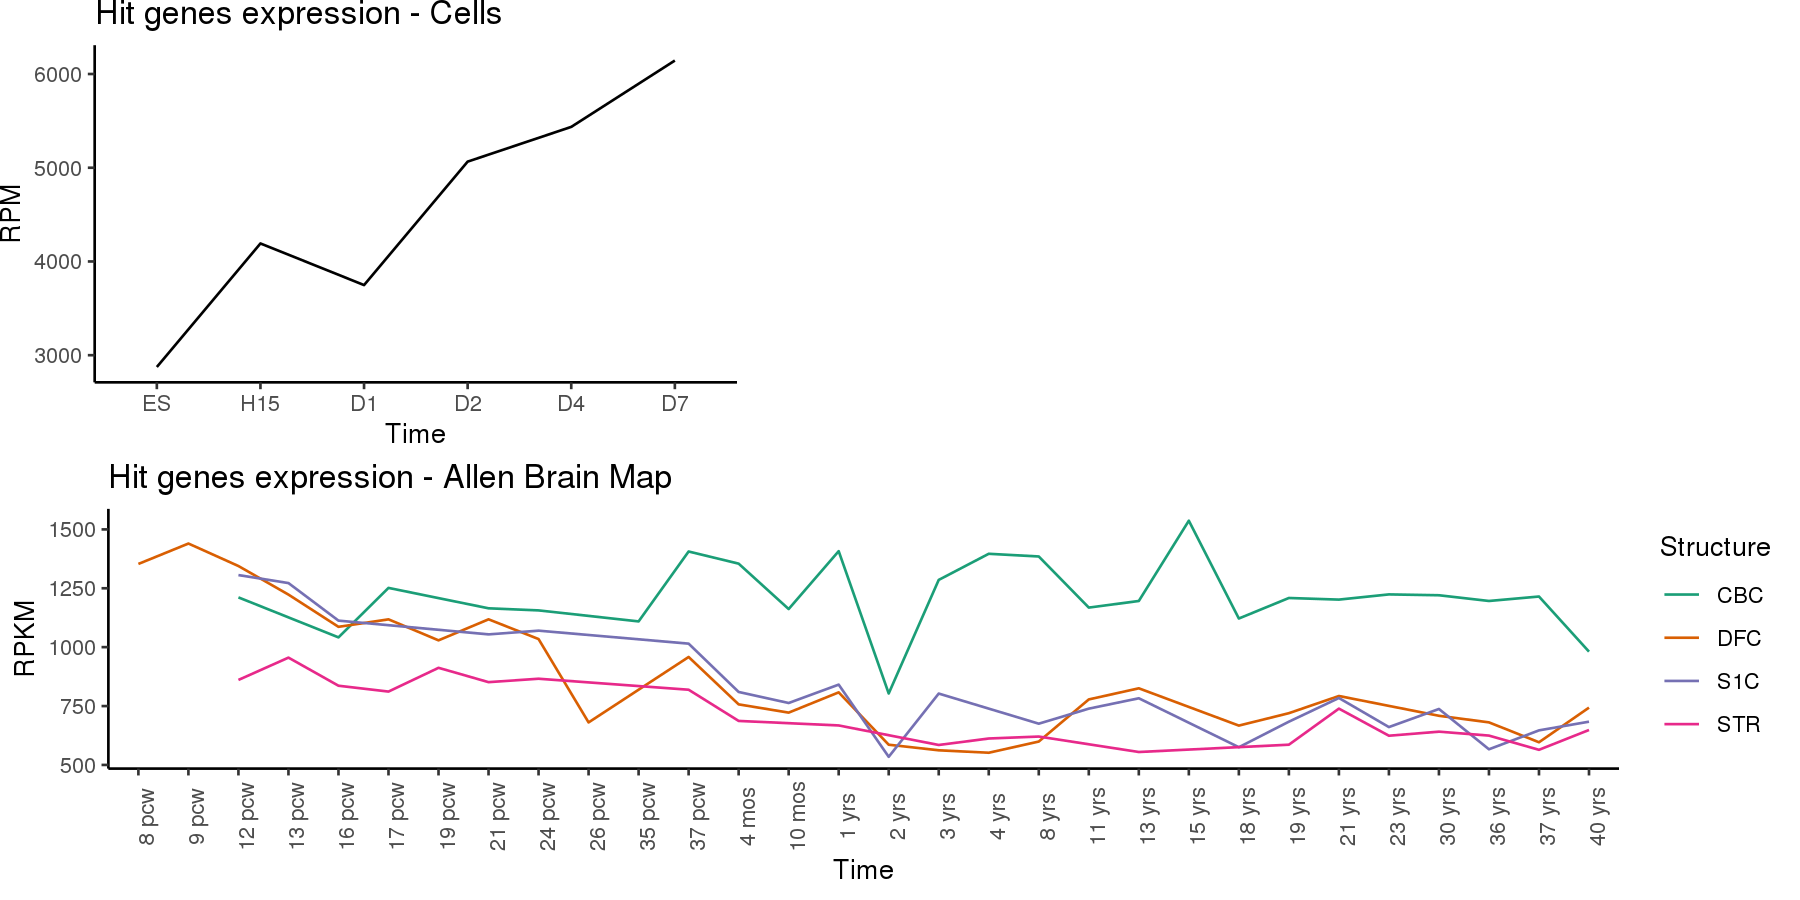

In [1409]:
gridExtra::grid.arrange(gg_hits_expr1, gg_hits_expr2, nrow = 2)

Box Plot

In [2134]:
# group time points into groups of time

# pcw_stage1: pcw 1 - 13
# pcw_stage2: pcw 14 - 26
# pcw_stage3: pcw 27 - 40
# toddler: 1 mos - 6 yrs
# teen: 7 yrs - 17 yrs
# adult: 18 yrs - 

groupTimePoints = function(time) {
    # convert X79.yrs to c('79', 'yrs')
    s = unlist(str_extract_all(time, '([0-9]+)|(pcw)|(mos)|(yrs)'))
    age = as.numeric(s[1])
    label = s[2]
    if (label == 'pcw') {
        time_group = case_when(age <= 13 ~ 'pcw1', 
                               age > 13 & age <= 27 ~ 'pcw2',
                               age > 27 ~ 'pcw3',)
    } else if (label == 'mos') {
        time_group = 'toddler'
    } else if (label == 'yrs') {
        time_group = case_when(age <= 6 ~ 'toddler', 
                               age > 6 & age < 18 ~ 'teen',
                               age >= 18 ~ 'adult',)
    } else {
        time_group = NA
    }
    return(time_group)
}

In [2162]:
age_group_labels = c(pcw1 = 'pcw 1 - 13', pcw2 = 'pcw 14 - 26', pcw3 = 'pcw 27 - 40', toddler = '1 mos - 6 yrs', teen = '7 - 17 yrs', adult = '18+ yrs')

In [2241]:
gg_hits_expr2_box = imap(brain_tf, ~ filter(.x, screen == 'Hit') %>%
                               select(-gene_name, -screen) %>%
                                pivot_longer(cols = -gene_id, names_to = 'life_stage', values_to = 'rpkm') %>%
                                mutate_at('life_stage', ~ map_chr(.x, groupTimePoints)) %>%
                                mutate_at('life_stage', ~ factor(.x, levels = c(paste0('pcw', 1:3), 'toddler', 'teen','adult'))) %>%
                                group_by(gene_id, life_stage) %>%
                                summarise(rpkm = median(rpkm)) %>%
                                ggplot() + stat_boxplot(aes(life_stage, rpkm, color = life_stage), geom = "errorbar", width = .5) +
                                    geom_boxplot(aes(life_stage, rpkm, color = life_stage), outlier.shape = NA) +
                                    geom_point(aes(life_stage, rpkm), alpha = .2, size = .5, position = 'jitter') +
                                    ylim(c(0,50))+
                                    scale_x_discrete(labels = age_group_labels) +
                                    scale_color_brewer(labels = age_group_labels, palette = 'Dark2', breaks = NULL) +
                                    labs(title = .y) +
                                    theme_classic() +
                                    theme(axis.text.x = element_text(angle = 90, vjust = .5))
                                )

In [2242]:
pdf('figures/BrainMap_Tissue_Hit_Expression_Boxplot.pdf', width = 11, height = 8)
gridExtra::grid.arrange(grobs = gg_hits_expr2_box, nrow = 1)
dev.off()

Warning message:
“Removed 36 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 36 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 52 rows containing missing values (geom_point).”
Warning message:
“Removed 17 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 17 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 39 rows containing missing values (geom_point).”
Warning message:
“Removed 16 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 16 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 44 rows containing missing values (geom_point).”
Warning message:
“Removed 12 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 12 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 29 rows containing missing values (geom_point).”


png 
  2

# Benford's law

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



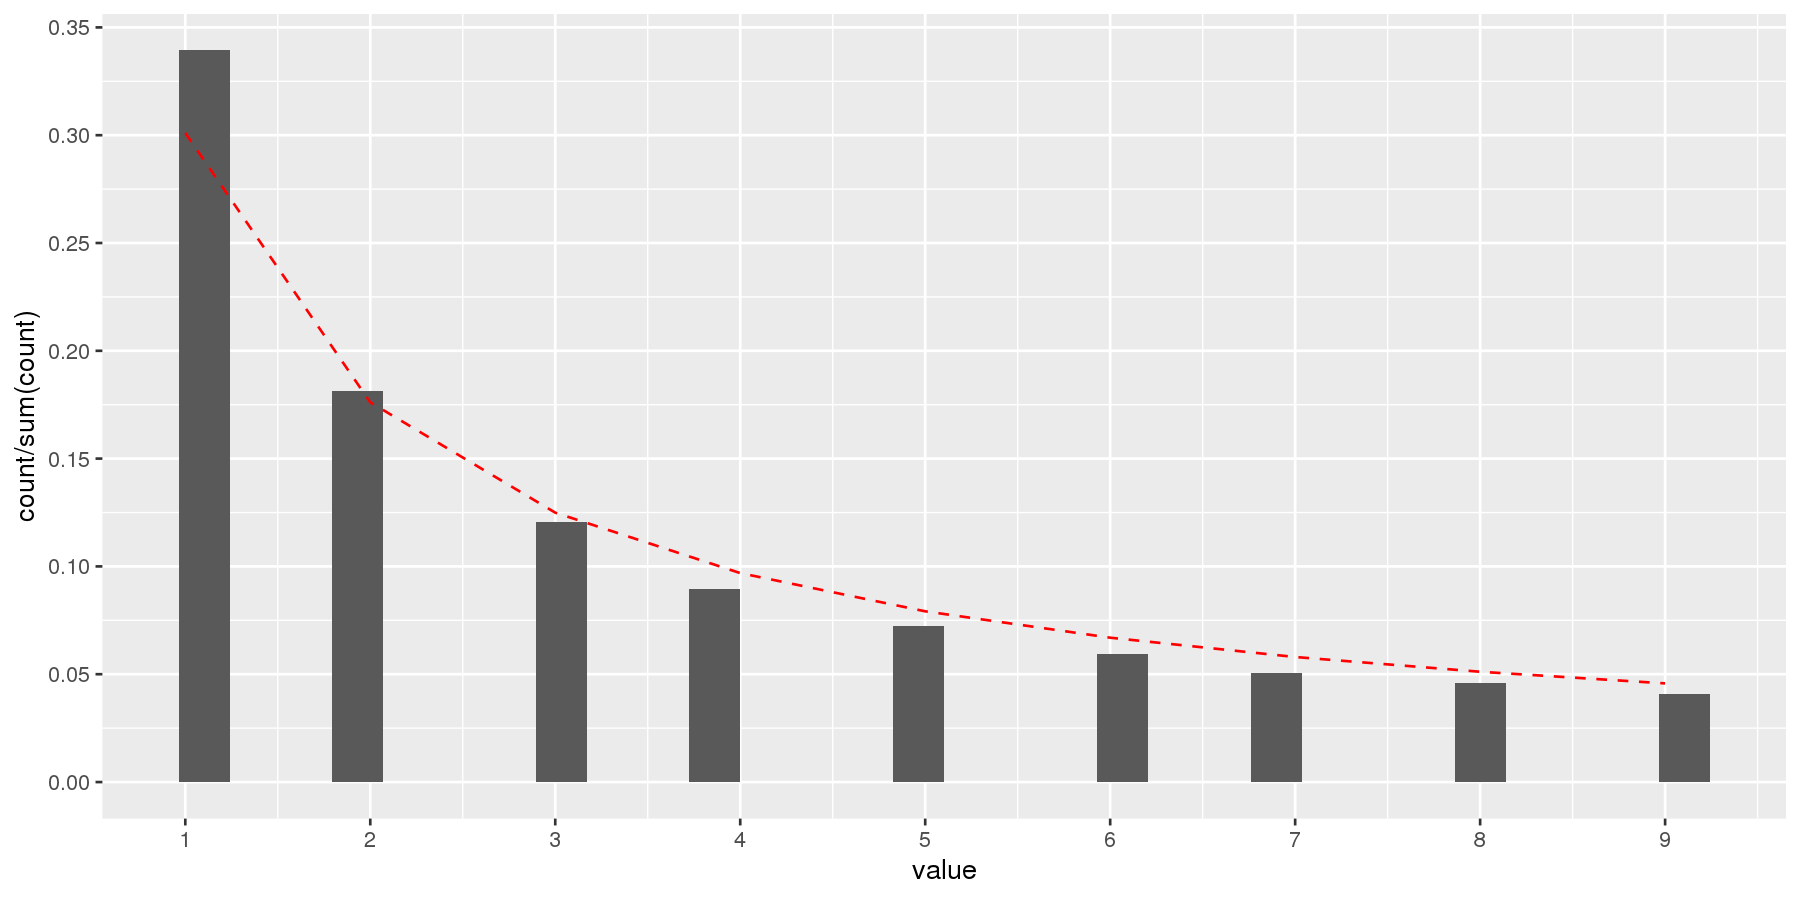

In [2266]:
rna_data$rawCounts$S01_B1 %>%
    as.character %>% str_extract('^[0-9]') %>% as.numeric %>%
    as.data.frame %>% rename('value' = '.') %>%
    filter(value > 0) %>%
    ggplot() + geom_histogram(aes(x = value, y = ..count../sum(..count..))) +
            geom_line(aes(x = value, y = log10(1 + 1/value)), color = 'red', linetype = 'dashed') +
            scale_x_continuous(breaks = 1:9) +
            scale_y_continuous(breaks = seq(0,1,.05))

<br><br><br><br><br><br>

---

# HELP DOCS